In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install copulas
!pip install torch_geometric
import copulas.multivariate
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv
import matplotlib.pyplot as plt
import torch.optim as optim
from torch_geometric.nn import GCNConv  # Graph Neural Network (GNN) layer
from sklearn.preprocessing import MinMaxScaler
import math
!pip install captum
from captum.attr import IntegratedGradients
from scipy.fftpack import fft, ifft
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2
from matplotlib import gridspec
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from numpy.linalg import LinAlgError
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

In [43]:
save = False

# Functions

In [2]:
def wavelet(Y, dj=0.025):
    """
    Perform a Continuous Wavelet Transform (CWT) on a time series using the Morlet wavelet, calculating its power spectrum.

    :param Y: NumPy array of the original time series data to be analyzed.
    :param dj: Float, optional, specifying the spacing between discrete scales for the wavelet transform. Defaults to 0.025.
    :return: A dictionary containing the wavelet transform ('wave'), associated periods ('period'), scales used ('scale'), wavelet power spectrum ('power'), cone of influence ('coi'), and average power across all times for each scale ('avg_power').
    """
    
    DT = 1/12  # Timestep for monthly data
    pad = 1  # Pad data
    param = 6  # Wavenumber for Morlet
    s0 = DT  # Standard smallest resolvable scale
    n1 = len(Y)  # Total observations
    J1 = int(np.floor((np.log2(n1 * DT / s0)) / dj)) # Equation 10

    # Center and optionally pad the time series to nearest base 2 power
    x = (Y - np.mean(Y))
    if pad == 1:
        base2 = int(np.trunc(np.log(n1) / np.log(2) + 0.4999))
        x = np.concatenate((x, np.zeros(2 ** (base2 + 1) - n1)))

    n = len(x)  # Length with pad, nearest base 2 power

    # Construct wavenumber array
    k = np.arange(1, int(n / 2) + 1)
    k = k * ((2 * np.pi) / (n * DT))
    k = np.concatenate(([0], k, -np.flip(k[:int((n - 1) / 2)])))

    # Compute FFT of the (padded) time series
    f = fft(x)

    # Construct scale array and initialize wave array
    scale = s0 * 2 ** (np.arange(0, J1 + 1) * dj) # Equation 9
    wave = np.zeros((J1 + 1, n), dtype=complex) 

    for a1 in range(J1 + 1):
        scl = scale[a1]
        expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
        norm = np.sqrt(scl * k[1]) * (np.pi ** (-0.25)) * np.sqrt(n)
        daughter = norm * np.exp(expnt) * (k > 0)
        wave[a1, :] = ifft(f * daughter) / n

    fourier_factor = (4 * np.pi) / (param + np.sqrt(2 + param ** 2))
    period = fourier_factor * scale

    # Calculate coi
    lengths = np.concatenate((np.arange(1, np.floor((n1 + 1) / 2) + 1), np.arange(1, np.floor(n1 / 2) + 1)[::-1]))
    coi = fourier_factor / np.sqrt(2) * lengths * DT

    wave = wave[:, :n1]  # Remove padding
    power = (np.abs(wave) ** 2)/np.var(wave) # Calculate normalized power spectrum
    avg_power = np.mean(power, axis=1)

    result = {'wave': wave, 'period': period, 'scale': scale, 'power': power, 'coi': coi, 'avg_power': avg_power}
    return result


def transform_data(time_series, detrended, data_type, plot=False):
    """
    Generates QQ plots for original and detrended data, performs a Box-Cox transformation on the detrended data,
    and plots the QQ plot of the transformed data.
    
    Parameters:
    - time_series: The original time series data.
    - detrended: The detrended time series data.
    - data_type: A string representing the type of data (e.g., "Temperature", "Rainfall").
    
    Returns:
    - A tuple containing the transformed time series and the lambda value of the Box-Cox transformation.
    """

    if plot:
        # QQ Plot for original data versus detrended
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns, and optional figure size
    
        # QQ Plot for original data
        stats.probplot(time_series, dist="norm", plot=axs[0])
        axs[0].set_title(f"QQ Plot of Original {data_type} Data")
        axs[0].set_ylabel("Ordered Values")
        axs[0].set_xlabel("Theoretical Quantiles")
        axs[0].grid(True)
    
        # QQ Plot for detrended data
        stats.probplot(detrended, dist="norm", plot=axs[1])
        axs[1].set_title(f"QQ Plot of Detrended {data_type} Data")
        axs[1].set_ylabel("Ordered Values")
        axs[1].set_xlabel("Theoretical Quantiles")
        axs[1].grid(True)
    
        plt.show()

    # Boxcox transform for detrended data
    shift = abs(min(detrended)) + 1
    timeseries_boxcox, lambda_boxcox = stats.boxcox(detrended + shift)

    if plot:
        # Plot Transform
        stats.probplot(timeseries_boxcox, dist="norm", plot=plt)
        plt.title(f"QQ Plot of Box-Cox Transformed {data_type} Data")
        plt.ylabel("Ordered Values (Transformed)")
        plt.xlabel("Theoretical Quantiles")
        plt.grid(True)
        plt.show()

    return shift, timeseries_boxcox, lambda_boxcox


def CI(wlt, dat, conf, noise_type):
    """
    Calculate the confidence interval for a wavelet power spectrum. Based off of Torrence and Compo 1998.
    
    Parameters:
    - conf: Confidence level as a decimal (0-1).
    - dat: Time series data.
    - noise_type: 'r' for red noise, 'w' for white noise.
    
    Returns:
    - A dictionary with the significant levels ('sig') as the key.
    """
    na = len(dat)
    
    if noise_type == "r":
        model = sm.tsa.ARIMA(dat, order=(1, 0, 0) , trend='n').fit() # prevent intercept term #dat/10^10
        alpha = model.params[0] # Equation 15, extract lag-1 autocorr
        print(f'Red Noise AR1 Coefficient: {alpha}')
    else:
        alpha = 0 # For white noise, default 0
    
    ps = wlt['period']
    LP = len(ps)
    freq = 1 / ps
    
    CI = np.zeros(LP)  # Initialize confidence interval empty array
    
    for i in range(LP):
        P = (1 - (alpha**2)) / (1 + (alpha**2) - (2 * alpha * np.cos(2 * np.pi * freq[i])))  # Equation 16
        df = 2 * np.sqrt(1 + ((na / (2.32 * ps[i]))**2))  # Equation 23, 28, determine dof
        CI[i] = P * (chi2.ppf(conf, df) / df) # Equation 18, 26

    dict = wlt.copy()

    dict['sig'] = CI

    return dict


def reconstruct(WT, series_data, dj=0.025, lvl=0, only_coi=True, only_sig=True, rescale=True):
    """
    Reconstruct the time series from the wavelet transform.

    Parameters:
    WT (dict): Dictionary containing wavelet transform results and metadata.
    lvl (float): Minimum power level for reconstruction.
    only_coi (bool): Whether to use only the cone of influence for reconstruction.
    only_sig (bool): Whether to use only significant parts for reconstruction.
    rescale (bool): Whether to rescale the reconstructed series.

    Returns:
    x_r (np.ndarray): Reconstructed time series.
    """

    Wave = WT['wave']
    Power = WT['power'] 
    Avg_Power = WT['avg_power'] 
    Scale = WT['scale']
    Period = WT['period']
    
    sig = WT['sig']
    dt = 1/12 # for monthly
    nc = len(series_data)
    nr = len(Scale)

    # Prepare reconstruction components
    rec_waves = np.zeros((nr, nc))
    for s_ind in range(nr):
        rec_waves[s_ind, :] = (np.real(Wave[s_ind, :]) / np.sqrt(Scale[s_ind])) * dj * np.sqrt(dt) / (np.pi**(-1/4) * 0.776)

    # Apply filters
    rec_waves = rec_waves * (Power >= lvl)

    if only_sig and sig is not None:
        mask = ~(Avg_Power > sig)  # Identifies the rows where Avg_Power <= sig
        
        # Check if all rows are going to be masked
        if mask.all():
            warnings.warn("All rows will be masked. No significant wavelet periods identified.")
        
        # To get the values in 'Scale' corresponding to non-masked rows in 'rec_waves':
        non_masked_values = np.around(Scale[~mask], decimals=2)
        
        # Print the values from 'Scale' that correspond to non-masked rows
        if non_masked_values.size > 0:
            print("Significant scales:")
            print(non_masked_values)
        else:
            print("No significant scales identified.")
        
        # Mask these rows with np.nan
        rec_waves[mask, :] = np.nan
    
    if only_coi:
        coi = WT['coi']  # Assuming 'coi' is an array of cone of influence values
        for i in range(nc):
            for s_ind in range(nr):
                if Scale[s_ind] > 2**coi[i]:
                    rec_waves[s_ind, i] = np.nan

    # Compute reconstructed series
    x_r = np.nansum(rec_waves, axis=0)

    # Rescale the reconstructed time series
    if rescale:
        x_r = (x_r - np.mean(x_r)) * np.std(series_data) / np.std(x_r) + np.mean(series_data)

    return x_r, non_masked_values
    

def wavelet_plot(plt_dataset, siglvl, name = '', sigtest = 'default'):
    """
    Plot the wavelet power spectrum and the global wavelet spectrum of a time series. This function creates a comprehensive visualization of the wavelet analysis results, facilitating the examination of periodicities in the data and their significance against specified noise models.

    :param plt_dataset: A dictionary containing 'Power', 'Period', 'COI', 'Avg_Power', 'R_noise', and 'W_noise' keys representing the wavelet power spectrum data, periods, cone of influence, average power, and significance levels against red and white noise respectively.
    :param siglvl: A float specifying the significance level for the noise tests (e.g., 0.05 for 95% significance).
    :param sigtest: String, optional, indicating the type of significance test to apply. 'red' for red noise, 'white' for white noise, and 'default' for both. Defaults to 'default'.
    :return: None. The function generates and displays two plots: 1) The wavelet power spectrum, showing power as a function of time and period with areas under the cone of influence shaded. 2) The global wavelet power spectrum, comparing average power over time against significance levels derived from noise models.
    """
    
    fig = plt.figure(figsize=(16, 6))  # Adjusted figure size for horizontal layout

    # Adjust GridSpec for colorbar placement to the left of the first plot with extra space
    gs = gridspec.GridSpec(1, 4, width_ratios=[0.1, 2, 1, 0.1], wspace=0.1)
    
    # Define the start and end colors for your palette
    start_color = '#FFFFFF'
    midpoint_color = '#6699CC'  # White as the neutral midpoint color
    end_color = '#004488'
    
    # Create the custom diverging palette
    custom_palette = sns.blend_palette([start_color, midpoint_color, end_color], as_cmap=True)

    # Wavelet power spectrum subplot
    ax_cwt = fig.add_subplot(gs[1])
    max_power = np.max(plt_dataset['Power'])
    levels = np.linspace(0, max_power, 10)
    
    # Use custom palette for the contourf plot
    time = plt_dataset['Time']
    cs = ax_cwt.contourf(time, np.log2(plt_dataset['Period']), plt_dataset['Power'], 
                         levels=levels, cmap=custom_palette)
    
    ax_cwt.plot(np.arange(time[0], time[0]+len(plt_dataset['COI']), 1), np.log2(plt_dataset['COI']), 'k')
    ax_cwt.fill_between(np.arange(time[0], time[0]+len(plt_dataset['COI']), 1), np.log2(plt_dataset['COI']), np.log2(plt_dataset['Period'][-1]), color='gray', alpha=0.5)
    ax_cwt.set_title(f'Local Wavelet Power Spectrum', fontsize=15)
    ax_cwt.set_ylabel('Period (Years)', fontsize=14)
    ax_cwt.set_xlabel('Time', fontsize=14)
    ax_cwt.tick_params(axis='both', which='major', labelsize=13)
    ax_cwt.set_ylim(np.log2(32), np.log2(2.1))  # Restricting y-axis limits to 2 to 64 years
    ax_cwt.set_yticks(np.log2([4, 8, 16, 32]))
    ax_cwt.set_yticklabels([4, 8, 16, 32])
    
    # Create colorbar for the first subplot
    cbar = plt.colorbar(cs, ax=ax_cwt, orientation='vertical')
    cbar.ax.tick_params(labelsize=13)  # Adjust colorbar tick label size
    # Set the format of the colorbar labels to one decimal place
    cbar.formatter = FormatStrFormatter('%0.1f')
    cbar.update_ticks()
    
    # Global wavelet spectrum subplot
    ax_global = fig.add_subplot(gs[2])
    ax_global.plot(plt_dataset['Avg_Power'], plt_dataset['Period'], label='Power', linestyle='-')
    if sigtest == 'red':
        ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='red', label=f'Red Noise {int(siglvl*100)}%', linestyle='--')
    elif sigtest == 'white':
        ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='black', label=f'White Noise {int(siglvl*100)}%', linestyle='--')
    else:
        ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='red', label=f'Red Noise {int(siglvl*100)}%', linestyle='--')
        ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='black', label=f'White Noise {int(siglvl*100)}%', linestyle='--')
    ax_global.set_title(f'Global Wavelet Power Spectrum', fontsize=15)
    ax_global.set_xlabel('Power', fontsize=14)
    ax_global.tick_params(axis='both', which='major', labelsize=13)
    ax_global.set_yscale('log', base=2)  # Log scale for y-axis
    ax_global.invert_yaxis()  # To match R's scale_y_continuous(trans = reverselog_trans(2))
    ax_global.set_xlim([0, 5])  # Sets x-axis to range from 0 to 5
    ax_global.set_ylim([32, 2.1])  # Sets y-axis to range from 2 to 64
    
    # Set custom y-axis labels
    y_ticks = [2**x for x in range(2, 6)]  # Up to 128
    ax_global.set_yticks(y_ticks)  # Set y-ticks to be powers of two
    ax_global.set_yticklabels([str(y) for y in y_ticks])  # Use the actual numbers as labels

    fig.suptitle(f'{name} Gauge', fontsize=17)
    plt.legend(fontsize=14)
    plt.show()

In [3]:
# Encoder + Temporary Forecasting Head
class TransformerMTS_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, nhead=4):
        super(TransformerMTS_Encoder, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.pos_encoder, num_layers=num_layers)

    def forward(self, x):
        x = self.input_layer(x)  # Shape: [batch, seq_len, hidden_dim]
        x = self.transformer_encoder(x)  # Shape: [batch, seq_len, hidden_dim]
        embedding = x[:, -1, :]  # Final hidden state
        return embedding

class EncoderWithForecastHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pred_horizon, num_layers=2, nhead=4):
        super(EncoderWithForecastHead, self).__init__()
        self.encoder = TransformerMTS_Encoder(input_dim, hidden_dim, num_layers, nhead)
        self.forecast_head = nn.Linear(hidden_dim, output_dim * pred_horizon)
        self.pred_horizon = pred_horizon
        self.output_dim = output_dim

    def forward(self, x):
        embedding = self.encoder(x)
        out = self.forecast_head(embedding)
        out = out.view(-1, self.pred_horizon, self.output_dim)
        return out

In [4]:
# Function to create input-output sequences for multi-step forecasting
def create_sequences(data, target_columns, seq_length=120, pred_horizon=12):
    sequences, targets = [], []
    target_data = data[target_columns]

    for i in range(len(data) - seq_length - pred_horizon + 1):
        seq = data.iloc[i:i+seq_length].values  # Past `seq_length` months
        target = target_data.iloc[i+seq_length:i+seq_length+pred_horizon].values  # Next `pred_horizon` months
        sequences.append(seq)
        targets.append(target)

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [5]:
def knn_retrieve_and_blend(query_window, datastore, encoder, base_forecast, K=5, temperature=1.0, alpha=1.0):
    encoder.eval()
    with torch.no_grad():
        query = encoder(query_window).squeeze()

    # Compute distances to all points in the datastore
    distances = torch.stack([torch.norm(query - key) for key, _ in datastore])
    topk_indices = torch.topk(-distances, K).indices

    neighbors = [datastore[i] for i in topk_indices]
    weights = torch.softmax(-distances[topk_indices] / temperature, dim=0)
    neighbor_targets = torch.stack([y for _, y in neighbors])  # Shape: [K, pred_horizon, num_nodes]

    # Compute weighted kNN forecast
    knn_forecast = torch.sum(weights[:, None, None] * neighbor_targets, dim=0)

    # Distance-adaptive lambda blending weight
    avg_distance = distances[topk_indices].mean().item()
    lam = alpha / (avg_distance + alpha)

    # Final blended forecast
    blended_forecast = (1 - lam) * base_forecast + lam * knn_forecast
    return blended_forecast

In [6]:
def generate_forecasts(df, model, datastore, target_cities, seq_length, pred_horizon):
    """
    Returns a dictionary of actual and predicted values for each city over the last forecast window.
    """
    latest_qstart = len(df) - (seq_length + pred_horizon)
    query_window = torch.tensor(
        df.iloc[latest_qstart : latest_qstart + seq_length].values,
        dtype=torch.float32
    ).unsqueeze(0)

    base_forecast = model(query_window).squeeze()
    blended_np    = knn_retrieve_and_blend(query_window, datastore, model.encoder, base_forecast).detach().numpy()

    actual_future = df[target_cities].iloc[
        latest_qstart + seq_length : latest_qstart + seq_length + pred_horizon
    ].values

    forecast_index = pd.date_range(
        start=df.index[latest_qstart + seq_length],
        periods=pred_horizon,
        freq='MS'
    )

    return {
        "forecast_index": forecast_index,
        "actual": actual_future,
        "predicted": blended_np,
        "target_cities": target_cities
    }

In [7]:
# Function to get the first and last non-NA dates for each column
def get_valid_date_range(df):
    first_valid_dates = df.apply(lambda col: col.first_valid_index())
    last_valid_dates = df.apply(lambda col: col.last_valid_index())
    return first_valid_dates, last_valid_dates

In [8]:
def empirical_return_levels(df, cols, targets=(10, 100), resample_rule='A'):
    """
    Compute empirical return‐period levels (e.g. 10-yr, 100-yr) from monthly data.

    Parameters
    ----------
    df : pd.DataFrame
        Monthly data with a DatetimeIndex.
    cols : list[str]
        Column names to process.
    targets : tuple[float]
        Return periods (years) to extract.  Default (10, 100).
    resample_rule : str
        Pandas offset alias for annual aggregation.
        'A' = calendar year max;  e.g. 'A-SEP' for Oct–Sep water year.

    Returns
    -------
    pd.DataFrame
        Index = column names, columns = target return periods.
        Example columns: ['T10', 'T100'] for default targets.
    """
    results = {}
    t_arr = np.asarray(targets)

    for c in cols:
        # annual-maximum series
        ams = (
            df[c]
            .resample(resample_rule)
            .max()
            .dropna()
        )
        n = len(ams)
        if n < 2:
            raise ValueError(f"Series '{c}' has fewer than 2 annual maxima.")

        # Weibull plotting positions
        ams_sorted = ams.sort_values(ascending=False).reset_index(drop=True)
        rank = np.arange(1, n + 1)               # 1 … n
        exceed_prob = rank / (n + 1)             # P(X ≥ x)
        return_period = 1 / exceed_prob          # T (years)

        # Linear interpolation in log-space for stability (optional)
        rl = np.interp(t_arr, return_period[::-1], ams_sorted[::-1])

        results[c] = rl

    col_names = [f"T{int(t)}" for t in targets]
    return pd.DataFrame(results, index=col_names).T

# Parameters

In [9]:
# OSCILLATIONS
sigtest = 'default'   # Type of wavelet sigtest 'red' or 'white', default will plot both but use red for extraction
siglvl = 0.95  # choice of significance level for wavelet extraction, default is 0.95.

# FORECAST
seq_length = 60   # Use 7 to 10 years of past data
pred_horizon = 24
hidden_dim = 64
num_layers = 2   # Transformer Encoder Layers
lr = 0.001       # Learning rate
epochs = 100
batch_size = 16
early_stop = False

# Preprocess & Load

In [10]:
climate_ind = pd.read_csv('Climatological/climate_indices_no_pna.csv', parse_dates=[0], index_col=0)

In [11]:
merged_discharge = pd.read_csv("Discharge_Preprocess.csv", parse_dates=["datetime"], index_col="datetime")
merged_discharge = merged_discharge.apply(pd.to_numeric, errors='coerce')

In [12]:
# Ensure both indices have the same timezone
if climate_ind.index.tz is not None:
    climate_ind = climate_ind.tz_convert(None)
if merged_discharge.index.tz is not None:
    merged_discharge = merged_discharge.tz_convert(None)

# Get first and last non-NA dates for both datasets
first_valid_climate, last_valid_climate = get_valid_date_range(climate_ind)
first_valid_discharge, last_valid_discharge = get_valid_date_range(merged_discharge)

# Determine the latest of the first non-NA dates (max of min dates)
start_date = max(first_valid_climate.max(), first_valid_discharge.max())

# Determine the earliest of the last non-NA dates (min of max dates)
end_date = min(last_valid_climate.min(), last_valid_discharge.min())

# Clip the data to the valid date range
climate_filtered = climate_ind.loc[start_date:end_date]
discharge_filtered = merged_discharge.loc[start_date:end_date]

# Merge the filtered dataframes
merged_data = climate_filtered.merge(discharge_filtered, left_index=True, right_index=True, how='inner')

# Resample data to monthly frequency and compute the maximum for each month
all_data_mon_max = merged_data.resample('ME').max()

# Resample discharge data to monthly sums
discharge_mon_sum = merged_data.resample('ME').sum()

# Normalize each column: subtract mean and divide by std
discharge_normalized = (discharge_mon_sum - discharge_mon_sum.mean()) / discharge_mon_sum.std()

# Rename columns to have '_sum' suffix
discharge_normalized.columns = [f"{col}_sum" for col in discharge_normalized.columns]

# Merge monthly sums into the main DataFrame
all_data_mon_max = all_data_mon_max.join(discharge_normalized, how='left')
all_data_mon_max.index = all_data_mon_max.index.to_period('M').to_timestamp()

# Extract month from index
all_data_mon_max['month'] = all_data_mon_max.index.month

# Create cyclic (sin/cos) features
all_data_mon_max['sin_month'] = np.sin(2 * np.pi * all_data_mon_max['month'] / 12)

In [13]:
minn_mean = all_data_mon_max['minneapolis'].mean()
sl_mean = all_data_mon_max['st_louis'].mean()
kc_mean = all_data_mon_max['kansas_city'].mean()
clin_mean = all_data_mon_max['clinton'].mean()
minn_std = all_data_mon_max['minneapolis'].std()
sl_std = all_data_mon_max['st_louis'].std()
kc_std = all_data_mon_max['kansas_city'].std()
clin_std = all_data_mon_max['clinton'].std()

In [14]:
cols_to_process = ['minneapolis', 'clinton', 'kansas_city', 'st_louis']
rl_df = empirical_return_levels(all_data_mon_max, cols_to_process)

print(rl_df)

                       T10       T100
minneapolis   49334.782609    90300.0
clinton      220260.869565   307000.0
kansas_city  258478.260870   558000.0
st_louis     793173.913043  1050000.0


/tmp/ipykernel_2979/2195537229.py:30: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(resample_rule)


# Wavelet

In [15]:
# wavelet transform
siglvl_wave = 0.95  # choice of significance level for wavelet extraction, default is 0.95.
sigtest = 'default' # Type of wavelet sigtest 'red' or 'white', default will plot both but use red for extraction

/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


Processing minneapolis_norm ...
Red Noise AR1 Coefficient: 0.619431210670276


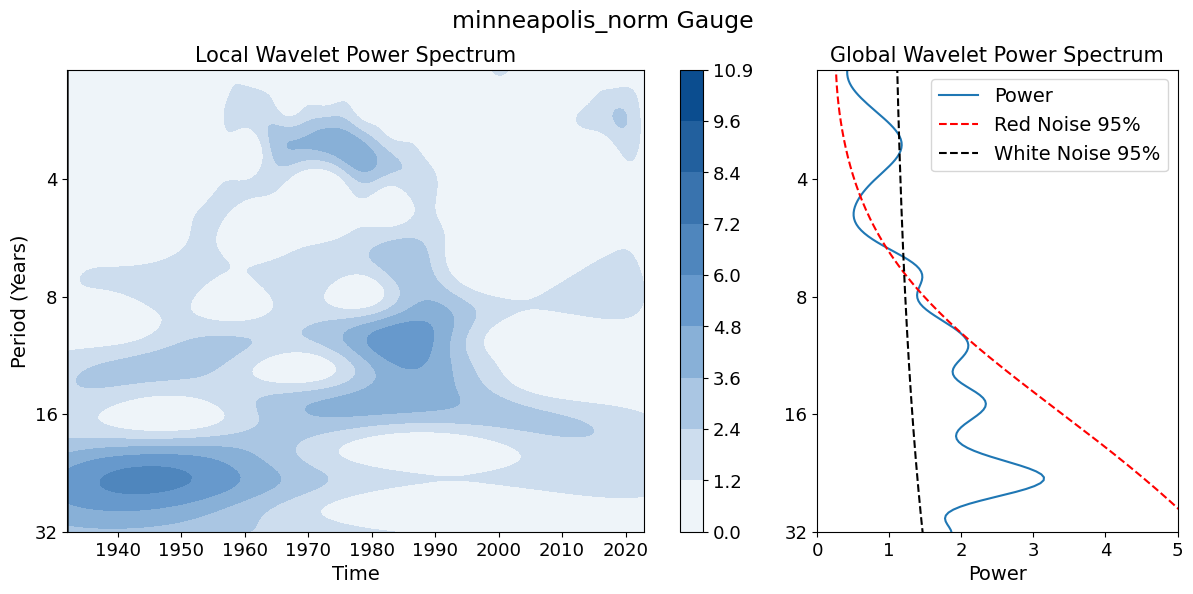

Red Noise Sig Test Results
Significant scales:
[0.36 0.37 0.38 0.38 0.39 0.4  0.4  0.41 0.42 0.42 0.43 0.44 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.66 0.67 0.68 0.69 0.7
 0.71 0.73 0.74 0.75 0.77 0.78 0.79 0.81 0.82 0.84 0.85 0.86 0.88 0.9
 1.05 1.06 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.38 1.4  1.43 1.45 1.48
 1.51 1.53 1.56 1.59 1.61 1.64 1.67 1.7  1.73 1.76 1.79 1.82 1.85 1.89
 1.92 1.95 1.99 2.02 2.06 2.09 2.13 2.17 2.2  2.24 2.28 2.32 2.36 2.4
 2.45 2.49 2.53 2.58 2.62 2.67 2.71 2.76 2.81 2.86 2.91 2.96 3.01 3.06
 3.12 3.17 3.23 3.28 3.34 3.4  3.46 3.52 3.58 3.64 3.71 3.77 3.84 3.9
 3.97 4.04 4.11 4.18 4.26 5.82 5.92 6.02 6.13 6.23 6.34 6.45 6.57 6.68
 6.8  6.92 7.04 7.16 7.29 7.41]
Processing clinton_norm ...
Red Noise AR1 Coefficient: 0.7061889206323837


/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


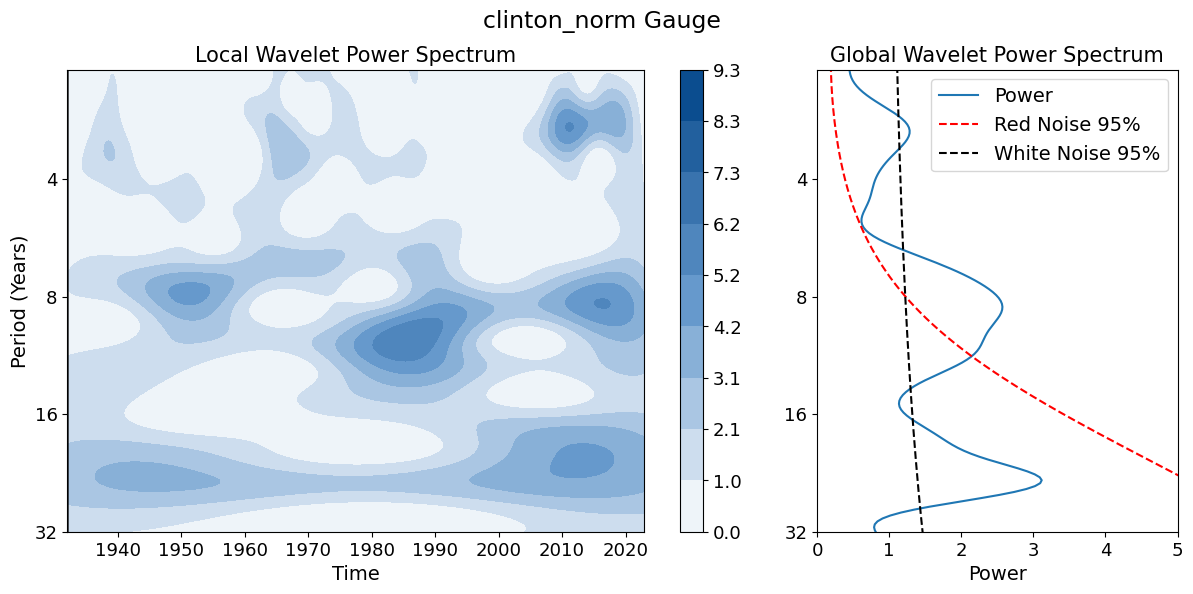

Red Noise Sig Test Results
Significant scales:
[ 0.36  0.37  0.38  0.38  0.39  0.4   0.4   0.41  0.42  0.42  0.43  0.44
  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.66
  0.67  0.68  0.69  0.7   0.71  0.73  0.74  0.75  0.77  0.78  0.79  0.81
  0.82  0.84  0.85  0.86  0.88  0.9   0.91  1.05  1.06  1.08  1.1   1.12
  1.14  1.16  1.18  1.2   1.22  1.24  1.27  1.29  1.31  1.33  1.36  1.38
  1.4   1.43  1.45  1.48  1.51  1.53  1.56  1.59  1.61  1.64  1.67  1.7
  1.73  1.76  1.79  1.82  1.85  1.89  1.92  1.95  1.99  2.02  2.06  2.09
  2.13  2.17  2.2   2.24  2.28  2.32  2.36  2.4   2.45  2.49  2.53  2.58
  2.62  2.67  2.71  2.76  2.81  2.86  2.91  2.96  3.01  3.06  3.12  3.17
  3.23  3.28  3.34  3.4   3.46  3.52  3.58  3.64  3.71  3.77  3.84  3.9
  3.97  4.04  4.11  4.18  4.26  4.33  4.41  4.48  4.56  4.64  4.72  4.81
  4.89  4.98  5.06  5.15  5.24  5.33  5.43  5.52  5.62  5.72  5.82  5.92
  6.02  6.13  6.23  6.34  6.45  6.57  6.68  6.8   6.92  7.04  7.16  7.29
  7.41

/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


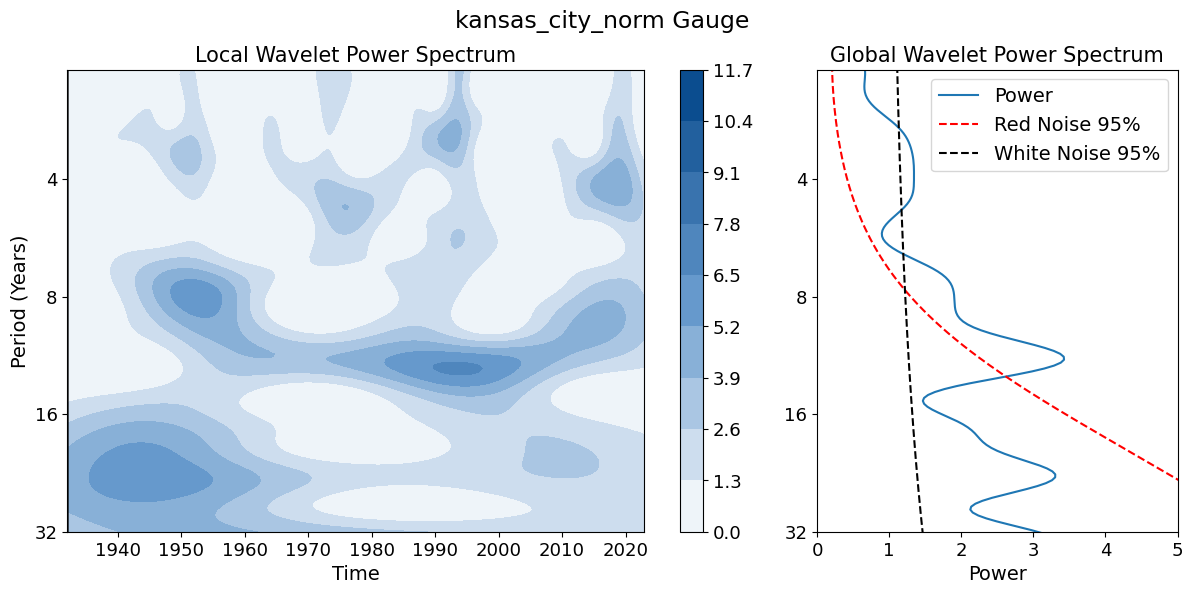

Red Noise Sig Test Results
Significant scales:
[ 0.59  0.6   0.61  0.62  0.63  0.64  0.66  0.67  0.68  0.69  0.7   0.71
  0.73  0.74  0.75  0.77  0.78  0.79  0.81  0.82  0.84  0.85  0.86  0.88
  1.43  1.45  1.48  1.51  1.53  1.56  1.59  1.61  1.64  1.67  1.7   1.73
  1.76  1.79  1.82  1.85  1.89  1.92  1.95  1.99  2.02  2.06  2.09  2.13
  2.17  2.2   2.24  2.28  2.32  2.36  2.4   2.45  2.49  2.53  2.58  2.62
  2.67  2.71  2.76  2.81  2.86  2.91  2.96  3.01  3.06  3.12  3.17  3.23
  3.28  3.34  3.4   3.46  3.52  3.58  3.64  3.71  3.77  3.84  3.9   3.97
  4.04  4.11  4.18  4.26  4.33  4.41  4.48  4.56  4.64  4.72  4.81  4.89
  4.98  5.06  5.15  5.24  5.33  5.43  5.52  5.62  5.72  5.82  5.92  6.02
  6.13  6.23  6.34  6.45  6.57  6.68  6.8   6.92  7.04  7.16  7.29  7.41
  7.54  7.67  7.81  7.94  8.08  8.23  8.37  8.52  8.66  8.82  8.97  9.13
  9.29  9.45  9.61  9.78  9.95 10.13 10.3  10.48 10.67 10.85 11.04 11.24
 11.43 11.63 11.84 12.04 12.25]
Processing st_louis_norm ...


/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


Red Noise AR1 Coefficient: 0.7708514949671024


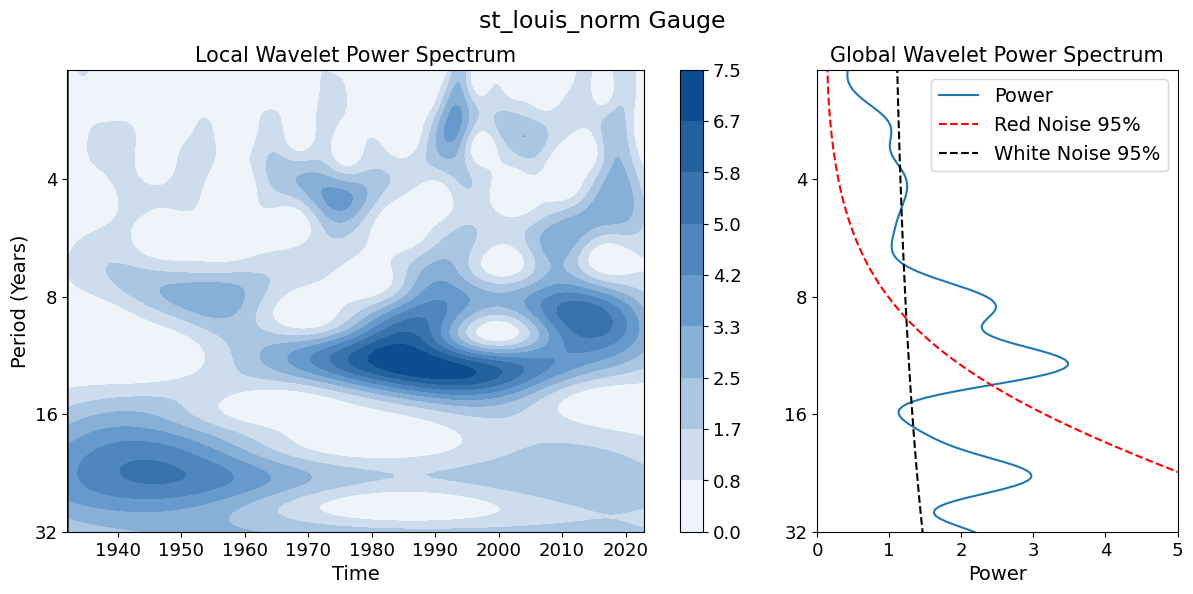

Red Noise Sig Test Results
Significant scales:
[ 0.37  0.38  0.38  0.39  0.4   0.4   0.41  0.42  0.42  0.55  0.56  0.57
  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.66  0.67  0.68  0.69  0.7
  0.71  0.73  0.74  0.75  0.77  0.78  0.79  0.81  0.82  0.84  0.85  0.86
  0.88  1.08  1.1   1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.27  1.29
  1.31  1.33  1.36  1.38  1.4   1.43  1.45  1.48  1.51  1.53  1.56  1.59
  1.61  1.64  1.67  1.7   1.73  1.76  1.79  1.82  1.85  1.89  1.92  1.95
  1.99  2.02  2.06  2.09  2.13  2.17  2.2   2.24  2.28  2.32  2.36  2.4
  2.45  2.49  2.53  2.58  2.62  2.67  2.71  2.76  2.81  2.86  2.91  2.96
  3.01  3.06  3.12  3.17  3.23  3.28  3.34  3.4   3.46  3.52  3.58  3.64
  3.71  3.77  3.84  3.9   3.97  4.04  4.11  4.18  4.26  4.33  4.41  4.48
  4.56  4.64  4.72  4.81  4.89  4.98  5.06  5.15  5.24  5.33  5.43  5.52
  5.62  5.72  5.82  5.92  6.02  6.13  6.23  6.34  6.45  6.57  6.68  6.8
  6.92  7.04  7.16  7.29  7.41  7.54  7.67  7.81  7.94  8.08  8.23  8.37
  8.52 

/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


Red Noise AR1 Coefficient: 0.601205445223015


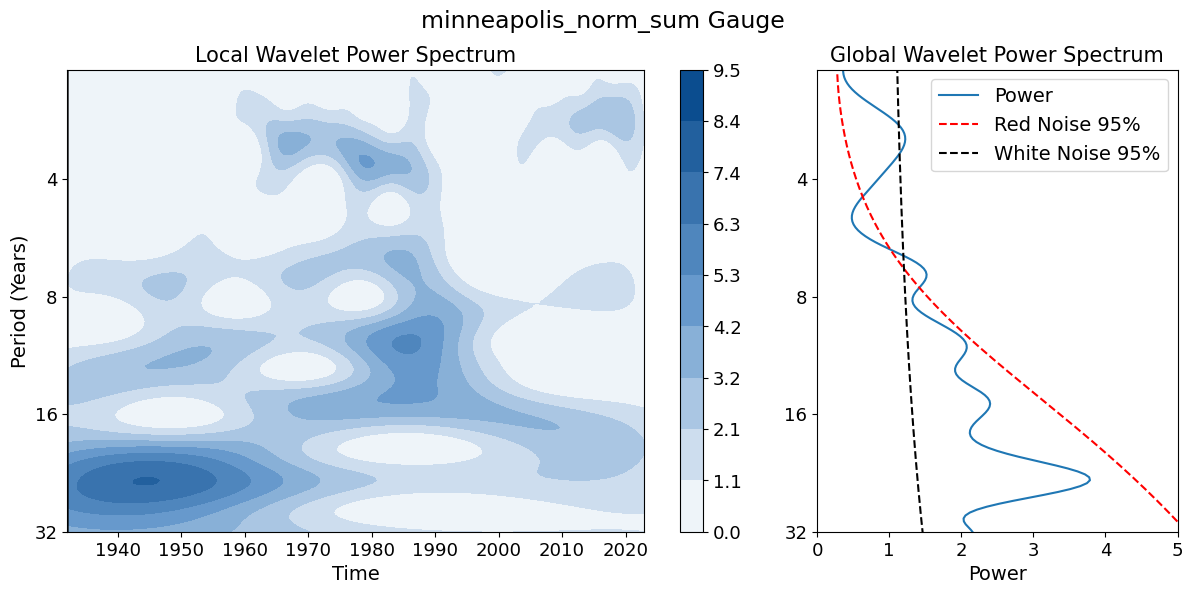

Red Noise Sig Test Results
Significant scales:
[0.38 0.38 0.39 0.4  0.4  0.41 0.42 0.42 0.43 0.56 0.57 0.58 0.59 0.6
 0.61 0.62 0.63 0.64 0.66 0.67 0.68 0.69 0.7  0.71 0.73 0.74 0.75 0.77
 0.78 0.79 0.81 0.82 0.84 0.85 0.86 0.88 1.45 1.48 1.51 1.53 1.56 1.59
 1.61 1.64 1.67 1.7  1.73 1.76 1.79 1.82 1.85 1.89 1.92 1.95 1.99 2.02
 2.06 2.09 2.13 2.17 2.2  2.24 2.28 2.32 2.36 2.4  2.45 2.49 2.53 2.58
 2.62 2.67 2.71 2.76 2.81 2.86 2.91 2.96 3.01 3.06 3.12 3.17 3.23 3.28
 3.34 3.4  3.46 3.52 3.58 3.64 3.71 3.77 3.84 3.9  3.97 4.04 4.11 4.18
 4.26 5.92 6.02 6.13 6.23 6.34 6.45 6.57 6.68 6.8  6.92 7.04 7.16 7.29]
Processing clinton_norm_sum ...
Red Noise AR1 Coefficient: 0.6542942369353857


/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


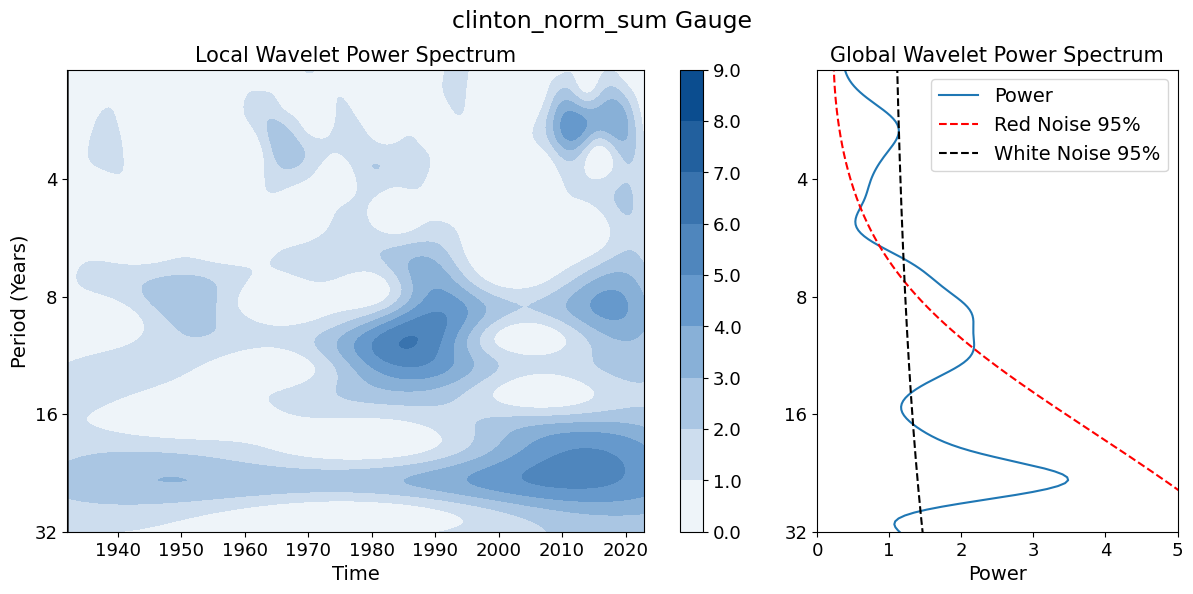

Red Noise Sig Test Results
Significant scales:
[ 0.38  0.38  0.39  0.4   0.4   0.41  0.42  0.42  0.43  0.55  0.56  0.57
  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.66  0.67  0.68  0.69  0.7
  0.71  0.73  0.74  0.75  0.77  0.78  0.79  0.81  0.82  0.84  0.85  0.86
  0.88  0.9   1.06  1.08  1.1   1.12  1.14  1.16  1.18  1.48  1.51  1.53
  1.56  1.59  1.61  1.64  1.67  1.7   1.73  1.76  1.79  1.82  1.85  1.89
  1.92  1.95  1.99  2.02  2.06  2.09  2.13  2.17  2.2   2.24  2.28  2.32
  2.36  2.4   2.45  2.49  2.53  2.58  2.62  2.67  2.71  2.76  2.81  2.86
  2.91  2.96  3.01  3.06  3.12  3.17  3.23  3.28  3.34  3.4   3.46  3.52
  3.58  3.64  3.71  3.77  3.84  3.9   3.97  4.04  4.11  4.18  4.26  4.33
  4.41  4.48  4.56  5.82  5.92  6.02  6.13  6.23  6.34  6.45  6.57  6.68
  6.8   6.92  7.04  7.16  7.29  7.41  7.54  7.67  7.81  7.94  8.08  8.23
  8.37  8.52  8.66  8.82  8.97  9.13  9.29  9.45  9.61  9.78  9.95 10.13
 10.3  10.48]
Processing kansas_city_norm_sum ...
Red Noise AR1 Coefficient: 0

/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


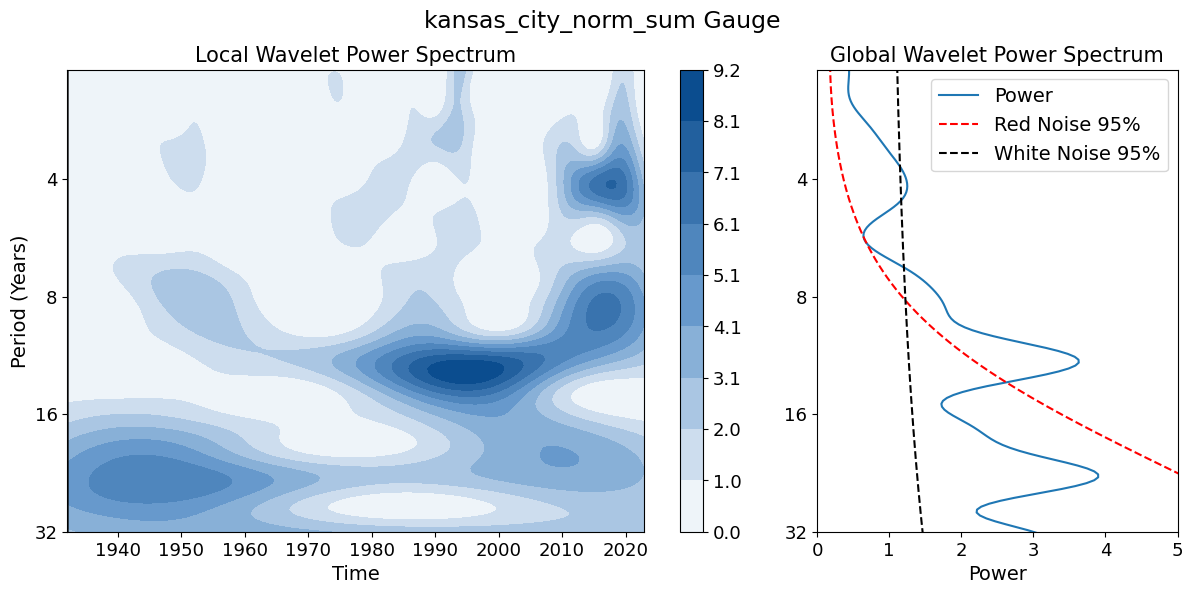

Red Noise Sig Test Results
Significant scales:
[ 0.66  0.67  0.68  0.69  0.7   0.71  0.73  0.74  0.75  0.77  0.78  0.79
  0.81  0.82  0.84  0.85  0.86  1.48  1.51  1.53  1.56  1.59  1.61  1.64
  1.67  1.7   1.73  1.76  1.79  1.82  1.85  1.89  1.92  1.95  1.99  2.02
  2.06  2.09  2.13  2.17  2.2   2.24  2.28  2.32  2.36  2.4   2.45  2.49
  2.53  2.58  2.62  2.67  2.71  2.76  2.81  2.86  2.91  2.96  3.01  3.06
  3.12  3.17  3.23  3.28  3.34  3.4   3.46  3.52  3.58  3.64  3.71  3.77
  3.84  3.9   3.97  4.04  4.11  4.18  4.26  4.33  4.41  4.48  4.56  4.64
  4.72  4.81  4.89  4.98  5.06  5.15  5.24  5.33  5.43  5.72  5.82  5.92
  6.02  6.13  6.23  6.34  6.45  6.57  6.68  6.8   6.92  7.04  7.16  7.29
  7.41  7.54  7.67  7.81  7.94  8.08  8.23  8.37  8.52  8.66  8.82  8.97
  9.13  9.29  9.45  9.61  9.78  9.95 10.13 10.3  10.48 10.67 10.85 11.04
 11.24 11.43 11.63 11.84 12.04 12.25 12.47 12.68]
Processing st_louis_norm_sum ...
Red Noise AR1 Coefficient: 0.742132647733028


/tmp/ipykernel_2979/2158036133.py:39: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/tmp/ipykernel_2979/2158036133.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0] # Equation 15, extract lag-1 autocorr


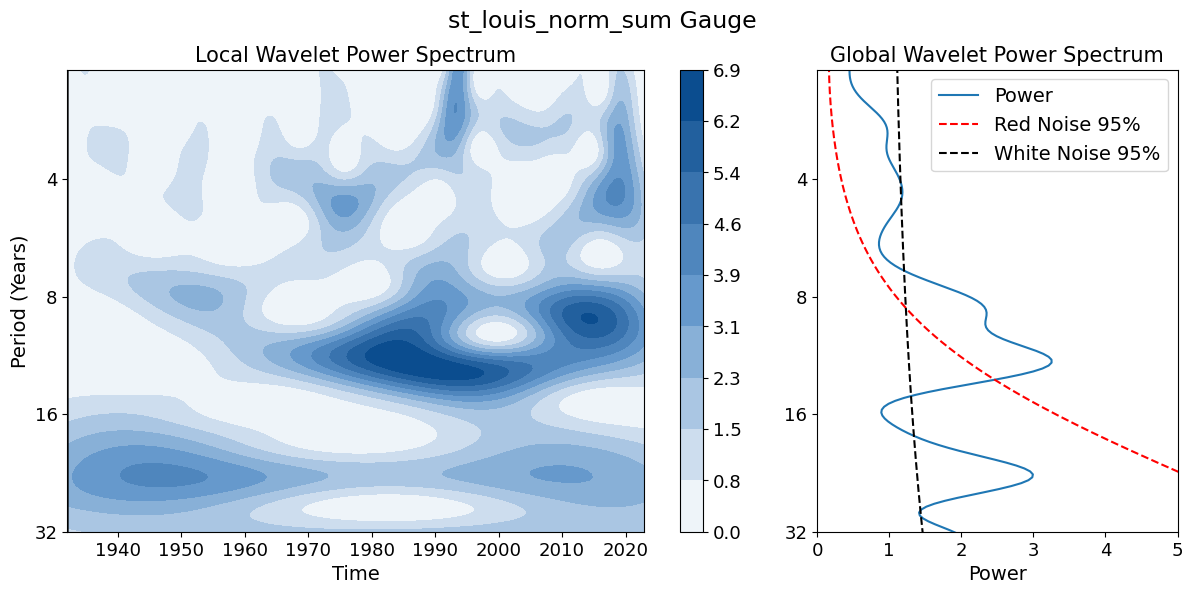

Red Noise Sig Test Results
Significant scales:
[ 0.4   0.4   0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.66  0.67  0.68
  0.69  0.7   0.71  0.73  0.74  0.75  0.77  0.78  0.79  0.81  0.82  0.84
  0.85  0.86  0.88  1.08  1.1   1.12  1.14  1.16  1.18  1.2   1.31  1.33
  1.36  1.38  1.4   1.43  1.45  1.48  1.51  1.53  1.56  1.59  1.61  1.64
  1.67  1.7   1.73  1.76  1.79  1.82  1.85  1.89  1.92  1.95  1.99  2.02
  2.06  2.09  2.13  2.17  2.2   2.24  2.28  2.32  2.36  2.4   2.45  2.49
  2.53  2.58  2.62  2.67  2.71  2.76  2.81  2.86  2.91  2.96  3.01  3.06
  3.12  3.17  3.23  3.28  3.34  3.4   3.46  3.52  3.58  3.64  3.71  3.77
  3.84  3.9   3.97  4.04  4.11  4.18  4.26  4.33  4.41  4.48  4.56  4.64
  4.72  4.81  4.89  4.98  5.06  5.15  5.24  5.33  5.43  5.52  5.62  5.72
  5.82  5.92  6.02  6.13  6.23  6.34  6.45  6.57  6.68  6.8   6.92  7.04
  7.16  7.29  7.41  7.54  7.67  7.81  7.94  8.08  8.23  8.37  8.52  8.66
  8.82  8.97  9.13  9.29  9.45  9.61  9.78  9.95 10.13 10.3  10.48 10.67
 10.

In [16]:
sig_scales_all = []
wavelet_datasets = {}  # Store wavelet data for later plotting

cols = ['minneapolis_norm', 'clinton_norm', 'kansas_city_norm','st_louis_norm', 'minneapolis_norm_sum', 'clinton_norm_sum', 'kansas_city_norm_sum','st_louis_norm_sum']

for column in cols:
    print(f"Processing {column} ...")
    col_copy = all_data_mon_max[column].copy()  # Make a copy
    col_copy.dropna(inplace=True)  # Drop NaN values
    data_source = column
    base_name = column.replace("_norm", "").replace("_sum", "")
    
    wlt = wavelet(col_copy)
    Cw = CI(wlt, col_copy, siglvl_wave, "r")
    C = CI(wlt, col_copy, siglvl_wave, "w")
    
    year_month = col_copy.index.to_period('M').to_timestamp()
    time = np.unique(year_month)
    
    # Global Wavelet Spectrum
    plt_dataset = {
        'Time': time,
        'Period': wlt['period'],
        'Avg_Power': wlt['avg_power'],
        'Power': wlt['power'],
        'COI': wlt['coi'],
        'W_noise': C['sig'],
        'R_noise': Cw['sig']
    }
    # Save wavelet plot data for base cities only (not _sum variants)
    if base_name not in wavelet_datasets:
        wavelet_datasets[base_name] = plt_dataset
        
    wavelet_plot(plt_dataset, siglvl_wave, data_source, sigtest)
    print("Red Noise Sig Test Results")
    reconstruction, sig_scales = reconstruct(Cw, col_copy)
    sig_scales_all.append(sig_scales)

    # Add reconstructed series to the full monthly dataframe
    wave_col_name = f"{column}_wave"
    reconstructed_series = pd.Series(reconstruction, index=col_copy.index, name=wave_col_name)

    # Merge into main DataFrame
    all_data_mon_max = all_data_mon_max.join(reconstructed_series, how='left')

    # Create lagged wavelet feature
    wave_lag_col_name = f"{column}_wave_lag"
    reconstructed_series_lagged = reconstructed_series.shift(1).rename(wave_lag_col_name)

    # Merge lagged wavelet feature
    all_data_mon_max = all_data_mon_max.join(reconstructed_series_lagged, how='left')

# Transformer

In [17]:
# Load and preprocess data (including all target cities)
df = all_data_mon_max[['nao', 'pdo', 'enso', 'gta',
                       'minneapolis_norm_wave', 'clinton_norm_wave', 'kansas_city_norm_wave', 'st_louis_norm_wave',
                       'minneapolis_norm_sum_wave', 'clinton_norm_sum_wave', 'kansas_city_norm_sum_wave', 'st_louis_norm_sum_wave',
                       'minneapolis_norm_wave_lag', 'clinton_norm_wave_lag', 'kansas_city_norm_wave_lag', 'st_louis_norm_wave_lag','sin_month',
                      ]].dropna()

wavelet_signal = all_data_mon_max[[
                       'minneapolis_norm_wave', 'clinton_norm_wave', 'kansas_city_norm_wave', 'st_louis_norm_wave'
                      ]].dropna()

# Define target variables (cities we want to predict)
target_cities = ['st_louis_norm_wave', 'minneapolis_norm_wave', 'clinton_norm_wave', 'kansas_city_norm_wave']

# 80 % train+val  |  20 % final test
split_80 = int(len(df)*0.8)
dev_df   = df.iloc[:split_80]
test_df  = df.iloc[split_80:]

split_val = int(len(df)*0.7)
train_df  = dev_df.iloc[:split_val]
val_df    = dev_df.iloc[split_val:]

# sequences
X_train, y_train = create_sequences(train_df, target_cities, seq_length, pred_horizon)
X_val,   y_val   = create_sequences(val_df,   target_cities, seq_length, pred_horizon)
X_test,  y_test  = create_sequences(test_df,  target_cities, seq_length, pred_horizon)

/tmp/ipykernel_448/2130423005.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


In [18]:
# ----------------- 2. MODEL SET-UP -----------------
input_dim     = X_train.shape[2]
output_dim    = len(target_cities)
model         = EncoderWithForecastHead(input_dim, hidden_dim, output_dim, pred_horizon)
criterion     = nn.MSELoss()
optimizer     = optim.Adam(model.parameters(), lr=lr)
train_batches = len(X_train) // batch_size
val_batches   = max(1, len(X_val)  // batch_size)

In [19]:
# --------------- 3. TRAINING LOOP ---------------
best_val   = float("inf")
patience   = 10
no_improve = 0

for epoch in range(epochs):
    # ---------- TRAIN ----------
    model.train()
    train_se = 0.0
    n_train  = 0
    for i in range(0, len(X_train), batch_size):
        xb, yb = X_train[i:i+batch_size], y_train[i:i+batch_size]
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_se += loss.item() * xb.size(0)   # accumulate SSE
        n_train  += xb.size(0)

    train_loss = train_se / n_train            # mean MSE on the epoch

    # ---------- VALIDATION ----------
    model.eval()
    with torch.no_grad():
        if len(X_val) == 0:                    # fallback to train metrics
            val_loss = train_loss
        else:
            val_se = 0.0
            n_val  = 0
            for i in range(0, len(X_val), batch_size):
                xb = X_val[i:i+batch_size]
                yb = y_val[i:i+batch_size]
                val_se += criterion(model(xb), yb).item() * xb.size(0)
                n_val  += xb.size(0)
            val_loss = val_se / n_val          # mean MSE

    # ---------- LOG ----------
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}/{epochs}"
              f" | Train {train_loss:.6f}"
              f" | Val {val_loss:.6f}")

    # ---------- EARLY-STOP ----------
    if val_loss < best_val - 1e-6:
        best_val   = val_loss
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            if early_stop:
                print("Early stopping triggered.")
                break

# restore best weights (optional)
model.load_state_dict(best_state)

Epoch   0/100 | Train 2.067224 | Val 1.350451
Epoch  10/100 | Train 1.211293 | Val 1.178939
Epoch  20/100 | Train 0.877527 | Val 1.705338
Epoch  30/100 | Train 0.654750 | Val 1.128526
Epoch  40/100 | Train 0.415039 | Val 1.078688
Epoch  50/100 | Train 0.392351 | Val 1.098516
Epoch  60/100 | Train 0.285683 | Val 1.205295
Epoch  70/100 | Train 0.282290 | Val 1.058513
Epoch  80/100 | Train 0.217963 | Val 0.975879
Epoch  90/100 | Train 0.198137 | Val 1.079580


<All keys matched successfully>

In [20]:
# ----------------- 4. FINAL TEST METRIC -----------------
model.eval()
with torch.no_grad():
    test_loss = sum(
        criterion(model(X_test[i:i+batch_size]), y_test[i:i+batch_size]).item()
        for i in range(0, len(X_test), batch_size)
    ) / max(1, len(X_test)//batch_size)

print(f"\nFinal **unseen** test MSE: {test_loss:.6f}")


Final **unseen** test MSE: 2.403975


In [21]:
datastore = []

model.eval()
with torch.no_grad():
    for i in range(len(X_train)):
        x_window = X_train[i:i+1]
        embedding = model.encoder(x_window).squeeze()
        future_target = y_train[i]
        datastore.append((embedding.cpu(), future_target.cpu()))

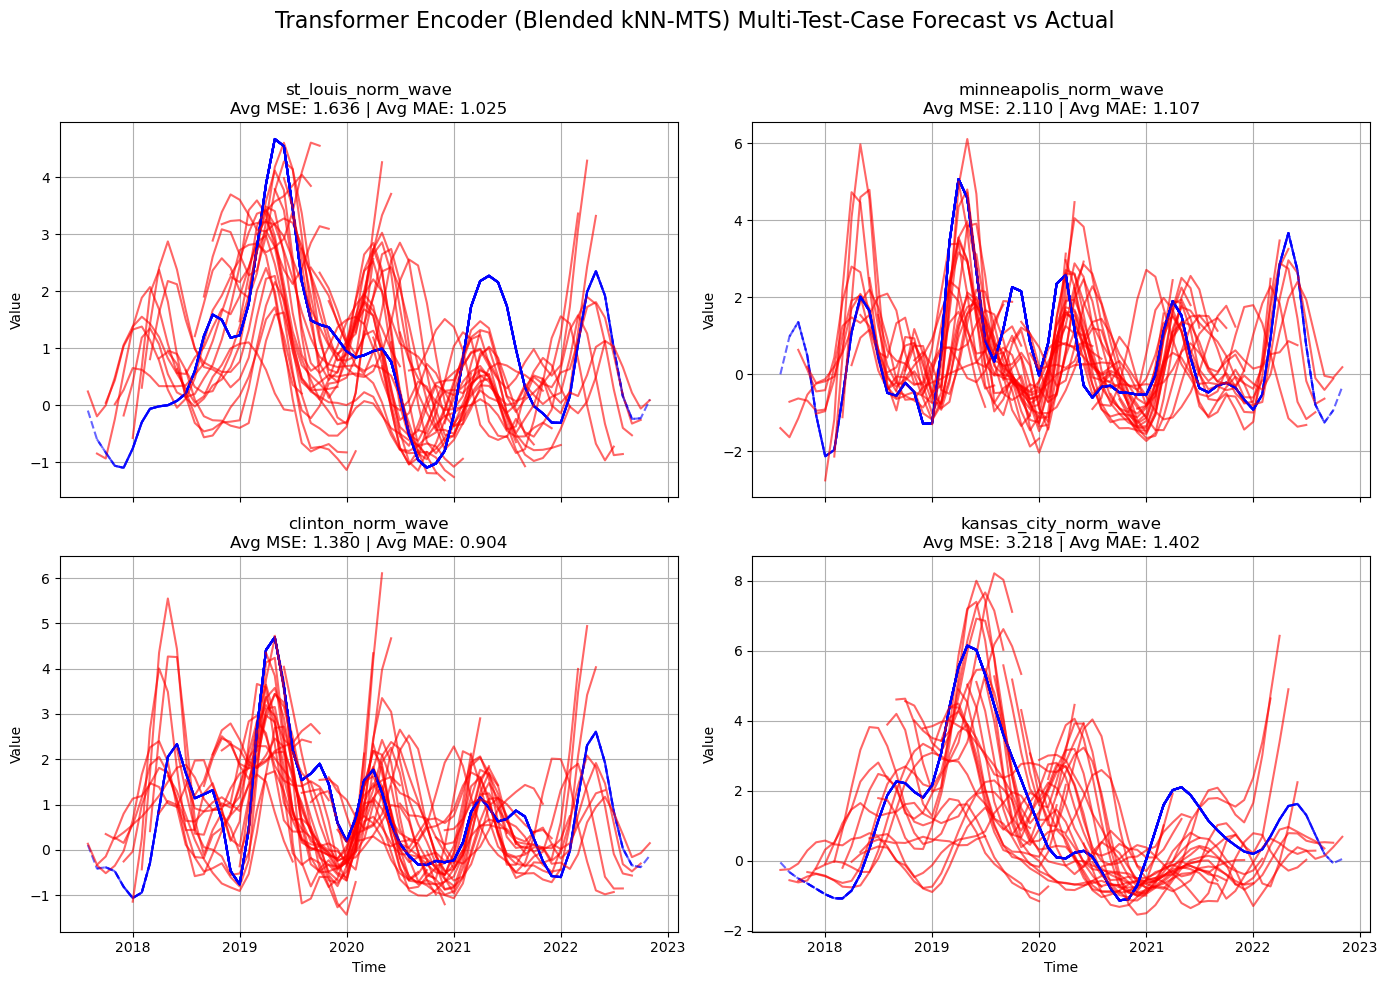

In [22]:
# Number of test cases to visualize
num_test_cases = 41  

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

forecasts = []

for idx, city in enumerate(target_cities):
    ax = axs[idx // 2, idx % 2]
    total_mse = 0
    total_mae = 0

    for i in range(num_test_cases):
        # Define the query window for this test case
        query_start = -(pred_horizon + seq_length + num_test_cases - i)
        query_window = torch.tensor(df.iloc[query_start:query_start + seq_length, :].values, dtype=torch.float32).unsqueeze(0)

        # Base Transformer forecast
        base_forecast = model(query_window).squeeze()

        # Blended forecast using kNN retrieval
        blended_forecast = knn_retrieve_and_blend(query_window, datastore, model.encoder, base_forecast)
        blended_forecast_np = blended_forecast.detach().numpy()
        forecasts.append(blended_forecast_np)

        # Extract actual future for comparison
        actual_future = df[target_cities].iloc[query_start + seq_length:query_start + seq_length + pred_horizon].values

        # Prepare forecast index
        forecast_index = pd.date_range(start=df.index[query_start + seq_length], periods=pred_horizon, freq='MS')

        actual = actual_future[:, idx]
        predicted = blended_forecast_np[:, idx]

        # Calculate MSE and MAE for this test case
        mse = mean_squared_error(actual, predicted)
        mae = np.mean(np.abs(actual - predicted))

        total_mse += mse
        total_mae += mae

        # Plot this test case
        ax.plot(forecast_index, actual, label=f"Actual {i+1}", linestyle="dashed", color="blue", alpha=0.6)
        ax.plot(forecast_index, predicted, label=f"Predicted {i+1}", linestyle="solid", color="red", alpha=0.6)

    # Average errors across all test cases
    avg_mse = total_mse / num_test_cases
    avg_mae = total_mae / num_test_cases

    ax.set_title(f"{city}\nAvg MSE: {avg_mse:.3f} | Avg MAE: {avg_mae:.3f}")
    ax.set_ylabel('Value')
    ax.grid(True)

# Common X-axis label
axs[-1, 0].set_xlabel('Time')
axs[-1, 1].set_xlabel('Time')

plt.suptitle('Transformer Encoder (Blended kNN-MTS) Multi-Test-Case Forecast vs Actual', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [32]:
def train_and_evaluate(df, target_cities, scenario, use_knn=False, rolling_eval=False):
    results = []

    seq_length    = 60  # 5 years
    pred_horizon  = scenario["test_len"]
    val_horizon   = scenario["val_len"]
    train_len     = scenario["train_len"]
    start         = scenario["train_start"]
    label         = scenario["label"]

    train_end = start + train_len
    val_end   = train_end + val_horizon
    test_end  = val_end + pred_horizon

    if test_end > len(df):
        print(f"[{label}] Skipping — exceeds data length.")
        return results

    train_df = df.iloc[start:train_end].copy()
    val_df   = df.iloc[train_end:val_end].copy()
    test_df  = df.iloc[val_end:test_end].copy()

    # Create training sequences
    X_train, y_train = create_sequences(train_df, target_cities, seq_length, pred_horizon)
    if len(X_train) == 0:
        print(f"[{label}] Skipping — not enough training sequences.")
        return results

    # Validation input: one-shot forecast from last train window
    if len(train_df) < seq_length or len(val_df) < pred_horizon:
        print(f"[{label}] Skipping — not enough data for validation forecast.")
        return results

    val_input = train_df.iloc[-seq_length:]
    val_target = val_df[target_cities].iloc[:pred_horizon]
    val_input_tensor = torch.tensor(val_input.values, dtype=torch.float32).unsqueeze(0)
    val_target_tensor = torch.tensor(val_target.values, dtype=torch.float32)

    # Model
    input_dim  = X_train.shape[2]
    output_dim = len(target_cities)
    model = EncoderWithForecastHead(input_dim, hidden_dim, output_dim, pred_horizon)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            xb, yb = X_train[i:i+batch_size], y_train[i:i+batch_size]
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(X_train)

        # Val loss (single forecast)
        model.eval()
        with torch.no_grad():
            val_pred = model(val_input_tensor).squeeze()
            val_loss = criterion(val_pred, val_target_tensor).item()

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"[{label}] Epoch {epoch:3d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    # Datastore for kNN
    datastore = []
    model.eval()
    with torch.no_grad():
        for i in range(len(X_train)):
            x_window = X_train[i:i+1]
            embedding = model.encoder(x_window).squeeze()
            future_target = y_train[i]
            datastore.append((embedding.cpu(), future_target.cpu()))

    # Forecast from val into test
    if len(val_df) < seq_length or len(test_df) < pred_horizon:
        print(f"[{label}] Skipping — not enough data for test forecast.")
        return results

    input_window = val_df.iloc[-seq_length:]
    query_window = torch.tensor(input_window.values, dtype=torch.float32).unsqueeze(0)

    base_forecast = model(query_window).squeeze()
    predicted = (
        knn_retrieve_and_blend(query_window, datastore, model.encoder, base_forecast).detach().numpy()
        if use_knn else base_forecast.detach().numpy()
    )

    actual = test_df[target_cities].iloc[:pred_horizon].values
    forecasts = [(actual, predicted)]

    # Forecast metrics per city
    for i, city in enumerate(target_cities):
        all_actual = np.concatenate([a[:, i] for a, _ in forecasts])
        all_pred   = np.concatenate([p[:, i] for _, p in forecasts])
        rmse = np.sqrt(mean_squared_error(all_actual, all_pred))
        mae  = mean_absolute_error(all_actual, all_pred)

        results.append({
            "scenario": label,
            "city": city,
            "rmse": rmse,
            "mae": mae,
            "use_knn": use_knn,
            "type": "forecast"
        })

    # Feature attribution (only for base model, not kNN)
    if not use_knn:
        city_attrs = compute_per_city_attributions(model, query_window, target_cities)

        for row in city_attrs:
            results.append({
                "scenario": label,
                "city": row["city"],
                "feature": row["feature"],
                "mean_attr": row["mean_attr"],
                "use_knn": use_knn,
                "type": "attribution"
            })

    return results

In [26]:
def generate_rolling_windows(df_len, train_len, val_len=60, test_len=60, step=60):
    """
    Generate rolling windows of (train_start, train_end, val_end, test_end) tuples.
    `step` is in months (e.g., 60 for 5 years).
    """
    windows = []
    max_start = df_len - (train_len + val_len + test_len)
    for train_start in range(0, max_start + 1, step):
        train_end = train_start + train_len
        val_end = train_end + val_len
        test_end = val_end + test_len
        windows.append({
            "label": f"{train_len//12}yr_train_{train_start//12}yr_start",
            "train_start": train_start,
            "train_len": train_len,
            "val_len": val_len,
            "test_len": test_len
        })
    return windows

In [30]:
def compute_feature_attributions(model, input_window, feature_names, target_idx=0):
    """
    Computes Integrated Gradients for the input window.
    Returns a dictionary mapping feature name to mean absolute attribution.
    """
    input_window.requires_grad_()
    ig = IntegratedGradients(model)

    # Use target=0: predicting the first city or timestep
    attributions, _ = ig.attribute(
        input_window,
        target=target_idx,
        return_convergence_delta=True
    )

    # Aggregate: mean absolute attribution over sequence and prediction horizon
    mean_attributions = attributions.abs().mean(dim=(0, 1)).detach().cpu().numpy()
    return dict(zip(feature_names, mean_attributions))

In [33]:
def compute_per_city_attributions(model, input_window, city_names, city_dim=2, time_dim=1):
    """
    Computes attributions separately for each city using Integrated Gradients.
    Returns a list of dicts with feature attributions per city.
    """
    from captum.attr import IntegratedGradients

    attributions_all = []
    input_window.requires_grad_()
    num_cities = len(city_names)
    feature_names = df.columns.tolist()

    for city_idx in range(num_cities):
        def forward_city_output(x):
            output = model(x)  # [1, horizon, num_cities]
            return output[:, :, city_idx].mean(dim=time_dim)  # [1] mean across time

        ig = IntegratedGradients(forward_city_output)
        attr = ig.attribute(input_window, return_convergence_delta=False)

        # Aggregate over time
        mean_attr = attr.abs().mean(dim=1).squeeze().detach().cpu().numpy()  # shape: [input_dim]
        city_results = [
            {
                "feature": fname,
                "city": city_names[city_idx],
                "mean_attr": mean_attr[i]
            }
            for i, fname in enumerate(feature_names)
        ]
        attributions_all.extend(city_results)

    return attributions_all

In [27]:
train_lengths = [300, 600, 840]  # 25, 50, 70 years in months
all_scenarios = []

for train_len in train_lengths:
    windows = generate_rolling_windows(len(df), train_len)
    all_scenarios.extend(windows)

In [36]:
results = []

for sc in all_scenarios:
    results.extend(train_and_evaluate(df, target_cities, sc, use_knn=False, rolling_eval=False))
    results.extend(train_and_evaluate(df, target_cities, sc, use_knn=True,  rolling_eval=False))

# Export
results_df = pd.DataFrame(results)
results_df.to_csv("rolling_forecast_results.csv", index=False)

[25yr_train_0yr_start] Epoch   0 | Train MSE: 2.6227 | Val MSE: 1.5396
[25yr_train_0yr_start] Epoch  10 | Train MSE: 1.4003 | Val MSE: 0.9598
[25yr_train_0yr_start] Epoch  20 | Train MSE: 1.0649 | Val MSE: 1.0927
[25yr_train_0yr_start] Epoch  30 | Train MSE: 0.7508 | Val MSE: 1.2670
[25yr_train_0yr_start] Epoch  40 | Train MSE: 0.5692 | Val MSE: 1.5570
[25yr_train_0yr_start] Epoch  50 | Train MSE: 0.4905 | Val MSE: 1.6256
[25yr_train_0yr_start] Epoch  60 | Train MSE: 0.3458 | Val MSE: 1.7186
[25yr_train_0yr_start] Epoch  70 | Train MSE: 0.3134 | Val MSE: 1.7473
[25yr_train_0yr_start] Epoch  80 | Train MSE: 0.2475 | Val MSE: 1.9290
[25yr_train_0yr_start] Epoch  90 | Train MSE: 0.2126 | Val MSE: 1.9153
[25yr_train_0yr_start] Epoch  99 | Train MSE: 0.1811 | Val MSE: 1.9432
[25yr_train_0yr_start] Epoch   0 | Train MSE: 2.6072 | Val MSE: 1.5431
[25yr_train_0yr_start] Epoch  10 | Train MSE: 1.3519 | Val MSE: 0.9925
[25yr_train_0yr_start] Epoch  20 | Train MSE: 1.0106 | Val MSE: 1.1501
[25yr_

In [88]:
# Load your results file
results_df = pd.read_csv("rolling_forecast_results.csv")

# Filter only forecast rows (where RMSE and MAE are stored)
metric_df = results_df[results_df["type"] == "forecast"]

# Drop rows with missing values
metric_df = metric_df.dropna(subset=["mae", "rmse"])

# Group by whether kNN was used and compute mean MAE and RMSE
summary = (
    metric_df.groupby("use_knn")[["mae", "rmse"]]
    .mean()
    .rename(index={False: "Transformer only", True: "Transformer + kNN"})
)

print("Average RMSE and MAE across all trials:")
print(summary)

Average RMSE and MAE across all trials:
                        mae      rmse
use_knn                              
Transformer only   1.192982  1.488734
Transformer + kNN  1.178256  1.467911


In [19]:
# Load results
results_df = pd.read_csv("rolling_forecast_results.csv")

# Filter only forecast rows (where RMSE and MAE are stored)
metric_df = results_df[results_df["type"] == "forecast"]

# Drop missing values
metric_df = metric_df.dropna(subset=["mae", "rmse", "city"])

# Compute mean MAE and RMSE grouped by use_knn and city
summary_by_city = (
    metric_df.groupby(["city", "use_knn"])[["mae", "rmse"]]
    .mean()
    .reset_index()
)

# Rename for readability
summary_by_city["Model"] = summary_by_city["use_knn"].map({False: "Transformer only", True: "Transformer + kNN"})
summary_by_city_transformer = summary_by_city.drop(columns="use_knn")

# Print summary grouped by city
print("Average RMSE and MAE per city:")
for city, group in summary_by_city_transformer.groupby("city"):
    print(f"\nCity: {city}")
    print(group[["Model", "mae", "rmse"]].to_string(index=False))


Average RMSE and MAE per city:

City: clinton_norm_wave
            Model      mae     rmse
 Transformer only 1.126803 1.390429
Transformer + kNN 1.089330 1.350623

City: kansas_city_norm_wave
            Model      mae     rmse
 Transformer only 1.326103 1.655526
Transformer + kNN 1.341450 1.672658

City: minneapolis_norm_wave
            Model      mae     rmse
 Transformer only 1.146285 1.445710
Transformer + kNN 1.117289 1.410196

City: st_louis_norm_wave
            Model      mae     rmse
 Transformer only 1.172738 1.463273
Transformer + kNN 1.164954 1.438169


In [20]:
# Filter for attribution results
if "type" in results_df.columns:
    attr_df = results_df[results_df["type"] == "attribution"]
else:
    raise ValueError("No attribution results found in the dataset.")

# Compute mean and std of attributions per feature per city
feature_ranks = (
    attr_df.groupby(["city", "feature"])["mean_attr"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_attr", "std": "std_attr"})
)

# Compute absolute mean_attr if needed (optional, for unsigned contributions)
feature_ranks["abs_mean_attr"] = feature_ranks["mean_attr"].abs()

# Compute relative importance per city (percent contribution)
feature_ranks["rel_importance"] = (
    feature_ranks.groupby("city")["abs_mean_attr"]
    .transform(lambda x: 100 * x / x.sum())  # convert to percent
)


# Compute city-level scaling factor
scaling_factors = (
    feature_ranks.groupby("city")["abs_mean_attr"]
    .sum()
    .apply(lambda x: 100 / x)
    .to_dict()
)

# Apply scaling factor to std to get error bars in same units as rel_importance
feature_ranks["rel_std"] = feature_ranks.apply(
    lambda row: row["std_attr"] * scaling_factors[row["city"]], axis=1
)

# Rank features by descending importance
feature_ranks["rank"] = (
    feature_ranks.groupby("city")["abs_mean_attr"]
    .rank(method="min", ascending=False)
)

# Sort for display
feature_ranks_sorted = feature_ranks.sort_values(["city", "rank"])

# Print with standard deviation and relative importance
for city, group in feature_ranks_sorted.groupby("city"):
    print(f"\nCity: {city}")
    print(
        group[["feature", "mean_attr", "std_attr", "rel_importance", "rel_std", "rank"]]
        .to_string(index=False, 
                   formatters={
                       "mean_attr": "{:.4f}".format,
                       "std_attr": "{:.4f}".format,
                       "rel_importance": "{:.2f}%".format,
                       "rel_std": "{:.2f}%".format,
                   })
    )


City: clinton_norm_wave
                  feature mean_attr std_attr rel_importance rel_std  rank
minneapolis_norm_sum_wave    0.0048   0.0032          8.68%   5.80%   1.0
    minneapolis_norm_wave    0.0045   0.0023          8.16%   4.24%   2.0
    clinton_norm_sum_wave    0.0041   0.0024          7.36%   4.26%   3.0
    kansas_city_norm_wave    0.0039   0.0023          6.99%   4.17%   4.0
                      pdo    0.0038   0.0028          6.97%   5.14%   5.0
   st_louis_norm_sum_wave    0.0035   0.0021          6.32%   3.90%   6.0
    clinton_norm_wave_lag    0.0034   0.0019          6.18%   3.44%   7.0
minneapolis_norm_wave_lag    0.0033   0.0020          6.06%   3.62%   8.0
   st_louis_norm_wave_lag    0.0031   0.0020          5.69%   3.54%   9.0
       st_louis_norm_wave    0.0031   0.0017          5.65%   3.07%  10.0
kansas_city_norm_sum_wave    0.0029   0.0016          5.33%   2.95%  11.0
        clinton_norm_wave    0.0029   0.0019          5.17%   3.51%  12.0
kansas_city_n

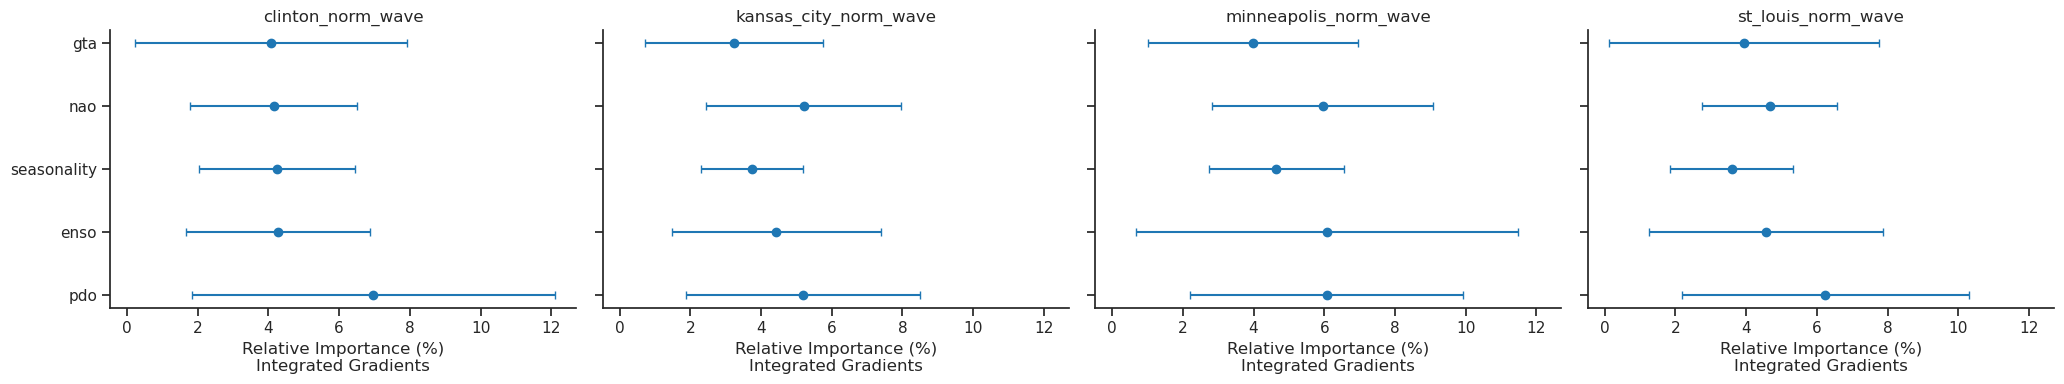

In [22]:
# ---- Filter and rename features ----
plot_df = feature_ranks_sorted.copy()

# Filter to desired features
keep_features = ["nao", "pdo", "enso", "gta", "sin_month"]
plot_df = plot_df[plot_df["feature"].isin(keep_features)]

# Rename for display
plot_df["feature"] = plot_df["feature"].replace({"sin_month": "seasonality"})

# Define consistent feature order
feature_order = ["nao", "pdo", "enso", "gta", "seasonality"]

# ---- Initialize facet plot ----
sns.set(style="ticks")

g = sns.FacetGrid(
    plot_df,
    col="city",
    col_wrap=4,
    sharey=True,
    height=4,
    aspect=1.3
)

# Plot points with error bars (horizontal)
def plot_with_error(data, **kwargs):
    ax = plt.gca()
    for i, (_, row) in enumerate(data.iterrows()):
        ax.errorbar(
            x=row["rel_importance"],
            y=row["feature"],
            xerr=row["rel_std"],
            fmt='o',
            color='tab:blue',
            capsize=3
        )

# Apply plotting function
g.map_dataframe(plot_with_error)

# Final adjustments
g.set_axis_labels("Relative Importance (%)\nIntegrated Gradients", "")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

In [24]:
# Initialize dictionary
ig_datasets = {}

# Strip suffixes and store cleaned city-level IG data
for city in plot_df["city"].unique():
    base_name = city.replace("_norm", "").replace("_wave", "").replace("_norm_wave", "")
    city_data = plot_df[plot_df["city"] == city].copy()
    ig_datasets[base_name] = city_data

/tmp/ipykernel_2979/136403261.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


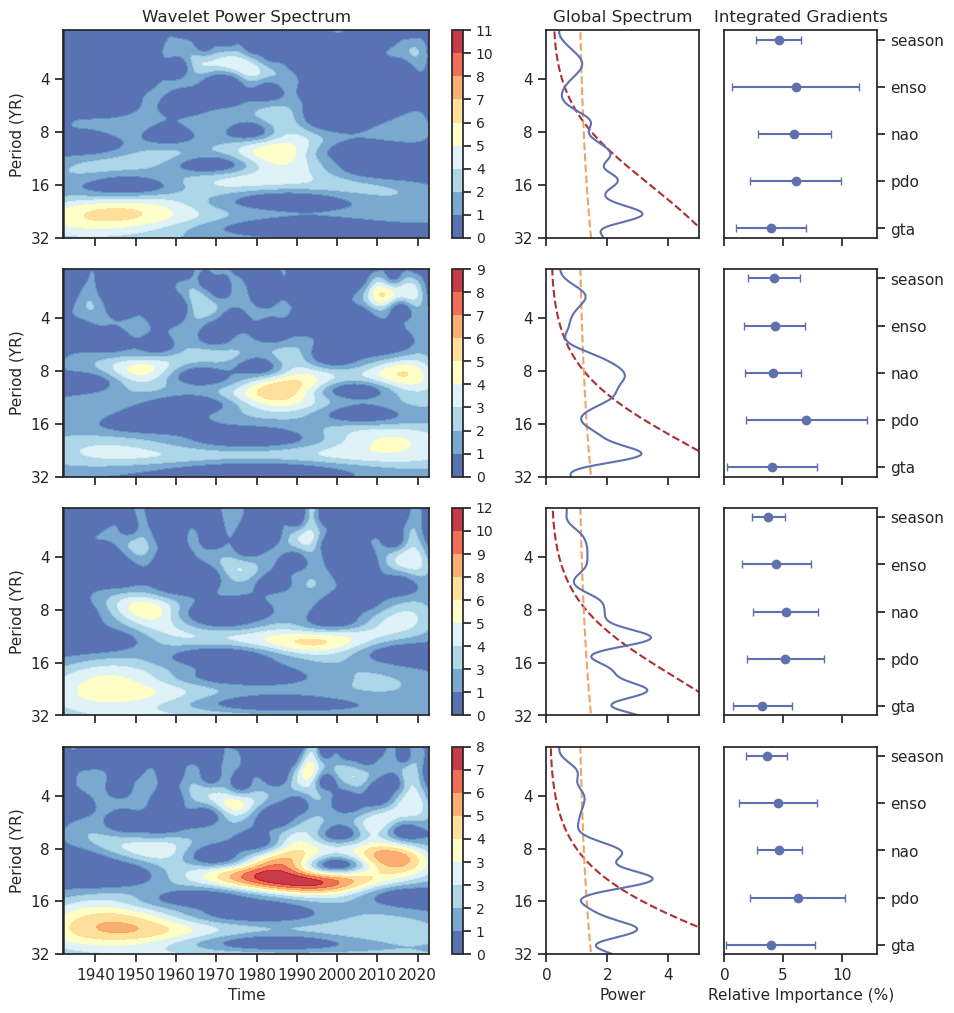

In [92]:
# Define cities and features to keep
cities = ["minneapolis", "clinton", "kansas_city", "st_louis"]
keep_features = ["nao", "pdo", "enso", "gta", "sin_month"]
feature_rename = {"sin_month": "seasonality"}
feature_order = ["gta", "pdo", "nao", "enso", "season"]

# Store per-city IG results for later plotting
ig_datasets = {}

# Filter to desired features
keep_features = ["nao", "pdo", "enso", "gta", "sin_month"]
plot_df = feature_ranks_sorted.copy()
plot_df = plot_df[plot_df["feature"].isin(keep_features)]
plot_df["feature"] = plot_df["feature"].replace({"sin_month": "season"})
plot_df["feature"] = pd.Categorical(plot_df["feature"], categories=feature_order, ordered=True)

# Save per-city IG results (strip suffixes to match base city names)
for raw_city in plot_df["city"].unique():
    base_city = raw_city.replace("_norm", "").replace("_wave", "").replace("_norm_wave", "")
    city_data = plot_df[plot_df["city"] == raw_city].copy()
    ig_datasets[base_city] = city_data

# Start the integrated plot
fig = plt.figure(figsize=(10.5, 12))
outer_gs = gridspec.GridSpec(4, 3, width_ratios=[3, 1, 1], wspace=0.1, hspace=0.15)

row_axes = []  # new list to store axes per row

for i, city in enumerate(cities):
    row = i
    plt_dataset = wavelet_datasets[city]

    if row == 0:
        ax_cwt = fig.add_subplot(outer_gs[row, 0])
        ax_global = fig.add_subplot(outer_gs[row, 1])
        ax_ig = fig.add_subplot(outer_gs[row, 2])
        ax_ig.set_xlim(0,13)
    
        # Save for sharing
        ax_cwt_first = ax_cwt
        ax_global_first = ax_global
        ax_ig_first = ax_ig
    else:
        ax_cwt = fig.add_subplot(outer_gs[row, 0], sharex=ax_cwt_first)
        ax_global = fig.add_subplot(outer_gs[row, 1], sharex=ax_global_first)
        ax_ig = fig.add_subplot(outer_gs[row, 2], sharex=ax_ig_first)
    
    row_axes.append((ax_cwt, ax_global, ax_ig))  # track each row's axes

    # -- Column 1: Wavelet power spectrum --
    max_power = plt_dataset['Power'].max()
    levels = np.linspace(0, max_power, 10)

    cs = ax_cwt.contourf(
        plt_dataset['Time'],
        np.log2(plt_dataset['Period']),
        plt_dataset['Power'],
        levels=levels,
        cmap="RdYlBu_r",
        alpha=0.85
    )
    ax_cwt.plot(
        np.arange(plt_dataset['Time'][0], plt_dataset['Time'][0] + len(plt_dataset['COI'])),
        np.log2(plt_dataset['COI']),
        'k'
    )
    ax_cwt.fill_between(
        np.arange(plt_dataset['Time'][0], plt_dataset['Time'][0] + len(plt_dataset['COI'])),
        np.log2(plt_dataset['COI']),
        np.log2(plt_dataset['Period'][-1]),
        color='gray', alpha=0.5
    )
    ax_cwt.set_ylabel('Period (YR)', fontsize=11)
    ax_cwt.set_ylim(np.log2(32), np.log2(2.1))
    ax_cwt.set_yticks(np.log2([4, 8, 16, 32]))
    ax_cwt.set_yticklabels([4, 8, 16, 32])

    cbar = plt.colorbar(cs, ax=ax_cwt, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)
    cbar.formatter = FormatStrFormatter('%.0f')
    cbar.update_ticks()

    # -- Column 2: Global wavelet spectrum --
    ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='#B02E2F', linestyle='--', label='Red Noise')
    ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='#EEA468', linestyle='--', label='White Noise')
    ax_global.plot(plt_dataset['Avg_Power'], plt_dataset['Period'], label='Power',color='#5E71AE')
    ax_global.set_yscale("log", base=2)
    ax_global.invert_yaxis()
    ax_global.set_xlim([0, 5])
    ax_global.set_ylim([32, 2.1])
    ax_global.set_yticks([2**x for x in range(2, 6)])
    ax_global.set_yticklabels([str(2**x) for x in range(2, 6)])

    # -- Column 3: IG relative importance with error bars --
    city_ig = ig_datasets.get(city, pd.DataFrame()).copy()
    city_ig["feature"] = pd.Categorical(city_ig["feature"], categories=feature_order, ordered=True)
    city_ig = city_ig.sort_values("feature", ascending=True)

    ax_ig.errorbar(
        city_ig["rel_importance"],
        city_ig["feature"],
        xerr=city_ig["rel_std"],
        fmt='o',
        color='#5E71AE',
        capsize=3
    )

    # Titles only on the first row
    if row == 0:
        ax_cwt.set_title("Wavelet Power Spectrum", fontsize=12)
        ax_global.set_title("Global Spectrum", fontsize=12)
        ax_ig.set_title("Integrated Gradients", fontsize=12)
    
    # X-axis labels only on the last row
    if row == len(cities) - 1:
        ax_cwt.set_xlabel('Time', fontsize=11)
        ax_global.set_xlabel("Power", fontsize=11)
        ax_ig.set_xlabel("Relative Importance (%)", fontsize=11)

    # Move y-axis ticks and labels to the right
    ax_ig.yaxis.tick_right()
    ax_ig.yaxis.set_label_position("right")
    ax_ig.set_xlim(0, None)

# Suppress bottom tick labels except on last row
for ax_cwt, ax_global, ax_ig in row_axes[:-1]:
    ax_cwt.tick_params(labelbottom=False)
    ax_cwt.set_xlabel("")
    ax_global.tick_params(labelbottom=False)
    ax_global.set_xlabel("")
    ax_ig.tick_params(labelbottom=False)
    ax_ig.set_xlabel("")

plt.tight_layout()
#if save:
plt.savefig("Plots/Climate.png", dpi=500)
plt.show()

# PCA PAR

In [23]:
def evaluate_pca_arima(df, target_cities, scenario, seasonal=True):
    results = []

    forecast_horizon = scenario["test_len"]
    train_start = scenario["train_start"]
    train_len = scenario["train_len"]
    val_len = scenario["val_len"]  # Not used here
    test_len = scenario["test_len"]
    label = scenario["label"]

    train_end = train_start + train_len
    test_start = train_end + val_len
    test_end = test_start + test_len

    if test_end > len(df):
        print(f"[{label} PCA-ARIMA] Skipping — exceeds data length.")
        return results

    train_data = df.iloc[train_start:train_end].values
    test_data = df.iloc[test_start:test_end].values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_data)

    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    n_components = train_data.shape[1]
    X_pca_reduced = X_pca[:, :n_components]

    # Forecast each PC
    pc_forecasts = []
    for i in range(n_components):
        try:
            if seasonal:
                model = SARIMAX(X_pca_reduced[:, i], order=(2, 0, 2), seasonal_order=(1, 0, 1, 12), trend='t')
            else:
                model = ARIMA(X_pca_reduced[:, i], order=(2, 1, 2))
            fitted = model.fit()
            forecast = fitted.forecast(steps=forecast_horizon)
        except Exception:
            forecast = np.repeat(X_pca_reduced[-1, i], forecast_horizon)
        pc_forecasts.append(forecast)

    pc_forecasts = np.array(pc_forecasts).T
    padded = np.hstack([pc_forecasts, np.zeros((forecast_horizon, df.shape[1] - n_components))])
    forecast_scaled = pca.inverse_transform(padded)
    forecast_original = scaler.inverse_transform(forecast_scaled)

    for i, city in enumerate(target_cities):
        actual = test_data[:, i]
        predicted = forecast_original[:, i]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        results.append({
            "scenario": label,
            "city": city,
            "rmse": rmse,
            "mae": mae,
            "use_knn": False,
            "type": "forecast",
            "model": "PCA-ARIMA"
        })

    return results

In [28]:
pca_arima_results = []

for sc in all_scenarios:
    pca_arima_results.extend(evaluate_pca_arima(df, target_cities, sc))

results_df = pd.DataFrame(pca_arima_results)
results_df.to_csv("rolling_forecast_pca_par_results.csv", index=False)

/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/notebook/lib/python3.12/

In [92]:
# Load results
results_df = pd.read_csv("rolling_forecast_pca_par_results.csv")

# Filter only forecast rows
metric_df = results_df[results_df["type"] == "forecast"].copy()

# Drop rows with missing values
metric_df = metric_df.dropna(subset=["mae", "rmse", "city"])

# Map model name for Transformer + kNN vs Transformer only (default)
metric_df["Model"] = metric_df.apply(
    lambda row: "Transformer + kNN" if row.get("use_knn", False) else (
        "PCA-ARIMA" if row.get("model") == "PCA-ARIMA" else "Transformer only"
    ),
    axis=1
)

# Compute mean MAE and RMSE per city and model
summary_by_city_pcapar = (
    metric_df.groupby(["city", "Model"])[["mae", "rmse"]]
    .mean()
    .reset_index()
)

# Print results
print("Average RMSE and MAE per city:")
for city, group in summary_by_city_pcapar.groupby("city"):
    print(f"\nCity: {city}")
    print(group[["Model", "mae", "rmse"]].to_string(index=False))

Average RMSE and MAE per city:

City: clinton_norm_wave
    Model   mae    rmse
PCA-ARIMA 0.702 0.85068

City: kansas_city_norm_wave
    Model      mae     rmse
PCA-ARIMA 0.222787 0.240127

City: minneapolis_norm_wave
    Model      mae     rmse
PCA-ARIMA 0.935045 1.118831

City: st_louis_norm_wave
    Model      mae     rmse
PCA-ARIMA 1.079351 1.357633


# ST-GNN

In [30]:
class STGNN_Encoder(nn.Module):
    def __init__(self, num_nodes, input_dim_per_node, hidden_dim, num_layers=2):
        super(STGNN_Encoder, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim

        self.gcn = GCNConv(input_dim_per_node, hidden_dim)
        self.node_gru = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)

    def forward(self, x_node, edge_index):
        batch_size, seq_length, num_nodes, input_dim = x_node.shape
        node_outputs = []

        for t in range(seq_length):
            xt = x_node[:, t, :, :]  # [batch, num_nodes, input_dim_per_node]
            xt = xt.reshape(-1, input_dim)  # [batch * num_nodes, input_dim_per_node]

            out = self.gcn(xt, edge_index)  # [batch * num_nodes, hidden_dim]
            out = out.view(batch_size, num_nodes, -1)  # [batch, num_nodes, hidden_dim]

            out = torch.mean(out, dim=1)  # [batch, hidden_dim]
            node_outputs.append(out.unsqueeze(1))  # Add time dimension

        gcn_seq = torch.cat(node_outputs, dim=1)  # [batch, seq_length, hidden_dim]

        # Pass through node GRU
        node_gru_out, _ = self.node_gru(gcn_seq)

        embedding = node_gru_out[:, -1, :]  # Final timestep embedding
        return embedding

In [31]:
class STGNN_WithForecastHead(nn.Module):
    def __init__(self, num_nodes, input_dim_per_node, hidden_dim, output_dim, pred_horizon, num_layers=2):
        super(STGNN_WithForecastHead, self).__init__()
        self.encoder = STGNN_Encoder(num_nodes, input_dim_per_node, hidden_dim, num_layers)
        self.forecast_head = nn.Linear(hidden_dim, output_dim * pred_horizon)
        self.pred_horizon = pred_horizon
        self.output_dim = output_dim

    def forward(self, x_node, edge_index):
        embedding = self.encoder(x_node, edge_index)
        out = self.forecast_head(embedding)
        out = out.view(-1, self.pred_horizon, self.output_dim)
        return out

In [72]:
def create_stgnn_sequences(node_data, target_data, target_cities, seq_length, pred_horizon, num_nodes, input_dim_per_node):
    """
    Create ST-GNN sequences:
    - node_data: DataFrame with features reshaped to [seq_length, num_nodes, input_dim_per_node]
    - target_data: DataFrame with city-level targets (may be same as node_data)
    """
    X_node, y = [], []
    total_samples = len(node_data) - seq_length - pred_horizon + 1

    for i in range(total_samples):
        node_seq = node_data.iloc[i:i+seq_length].values.reshape(seq_length, num_nodes, input_dim_per_node)
        target_seq = target_data[target_cities].iloc[i+seq_length:i+seq_length+pred_horizon].values

        X_node.append(node_seq)
        y.append(target_seq)

    return (
        torch.tensor(np.array(X_node), dtype=torch.float32),   # [batch, seq_len, num_nodes, input_dim_per_node]
        torch.tensor(np.array(y), dtype=torch.float32)         # [batch, pred_horizon, num_target_cities]
    )

In [79]:
def knn_retrieve_and_blend_stgnn(query_window, datastore, encoder, edge_index, base_forecast=None, K=5, temperature=1.0, alpha=1.0):
    """
    Retrieve k nearest neighbors in embedding space and optionally blend with base forecast.
    If base_forecast is None, return pure kNN forecast.
    """
    encoder.eval()
    with torch.no_grad():
        query_embedding = encoder(query_window, edge_index).squeeze()

    # Compute distances to all keys in datastore
    distances = torch.stack([torch.norm(query_embedding - key) for key, _ in datastore])
    topk_indices = torch.topk(-distances, K).indices  # Negative for top-k smallest

    # Get top-K neighbor embeddings and targets
    neighbors = [datastore[i] for i in topk_indices]
    weights = torch.softmax(-distances[topk_indices] / temperature, dim=0)

    # Stack neighbor targets and compute weighted sum
    neighbor_targets = torch.stack([y for _, y in neighbors])  # [K, pred_horizon, num_targets]
    knn_forecast = torch.sum(weights[:, None, None] * neighbor_targets, dim=0)  # [pred_horizon, num_targets]

    if base_forecast is None:
        return knn_forecast  # Pure kNN forecast

    # Optional: blend with base forecast using distance-adaptive lambda
    avg_distance = distances[topk_indices].mean().item()
    lam = alpha / (avg_distance + alpha)
    blended_forecast = (1 - lam) * base_forecast + lam * knn_forecast
    return blended_forecast

In [80]:
def train_and_evaluate_stgnn(df_node, df_all, target_cities, scenario, edge_index):
    results = []

    seq_length    = 60
    pred_horizon  = scenario["test_len"]
    val_horizon   = scenario["val_len"]
    train_len     = scenario["train_len"]
    start         = scenario["train_start"]
    label         = scenario["label"]

    train_end = start + train_len
    val_end   = train_end + val_horizon
    test_end  = val_end + pred_horizon

    if test_end > len(df_node):
        print(f"[{label}] Skipping — exceeds data length.")
        return results

    # Extract train, val, test
    train_data = df_node.iloc[start:train_end]
    val_data   = df_node.iloc[train_end:val_end]
    test_data  = df_node.iloc[val_end:test_end]

    # Build sequences
    num_nodes = 4
    input_dim_per_node = 3
    output_dim = len(target_cities)
    X_train, y_train = create_stgnn_sequences(
        node_data=train_data,
        target_data=df_all,  # or df_node if using the same
        target_cities=target_cities,
        seq_length=seq_length,
        pred_horizon=pred_horizon,
        num_nodes=num_nodes,
        input_dim_per_node=input_dim_per_node
    )

    if len(X_train) == 0:
        print(f"[{label}] Skipping — not enough training sequences.")
        return results

    # Build model
    model = STGNN_WithForecastHead(num_nodes, input_dim_per_node, hidden_dim, output_dim, pred_horizon, num_layers)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    batch_size = 16

    # Train
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            xb = X_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]
        
            # Skip short final batch
            if xb.shape[0] < batch_size:
                continue
        
            xb = xb.view(-1, seq_length, num_nodes, input_dim_per_node)
        
            optimizer.zero_grad()
            pred = model(xb, edge_index)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        if epoch % 10 == 0:
            print(f"[{label}] Epoch {epoch:3d} | Train Loss: {epoch_loss:.4f}")

    # Build kNN datastore from train
    datastore = []
    model.eval()
    with torch.no_grad():
        for i in range(len(X_train)):
            xb = X_train[i:i+1]
            emb = model.encoder(xb, edge_index).squeeze()
            datastore.append((emb.cpu(), y_train[i].cpu()))

    # Get val → test input
    query_window_raw = val_data.iloc[-seq_length:].values
    query_window = torch.tensor(query_window_raw, dtype=torch.float32).view(1, seq_length, num_nodes, input_dim_per_node)

    with torch.no_grad():
        knn_forecast = knn_retrieve_and_blend_stgnn(query_window, datastore, model.encoder, edge_index).detach().numpy()

    # Actual test target
    actual = df_node[target_cities].iloc[val_end:val_end + pred_horizon].values

    # Compute metrics
    for i, city in enumerate(target_cities):
        rmse = np.sqrt(mean_squared_error(actual[:, i], knn_forecast[:, i]))
        mae  = mean_absolute_error(actual[:, i], knn_forecast[:, i])
        results.append({
            "scenario": label,
            "city": city,
            "rmse": rmse,
            "mae": mae,
            "use_knn": True,
            "type": "forecast",
            "model": "STGNN"
        })

    return results

In [81]:
# Define the node features used in ST-GNN
node_features = [
    'minneapolis_norm_wave', 'minneapolis_norm_sum_wave', 'minneapolis_norm_wave_lag',
    'clinton_norm_wave', 'clinton_norm_sum_wave', 'clinton_norm_wave_lag',
    'kansas_city_norm_wave', 'kansas_city_norm_sum_wave', 'kansas_city_norm_wave_lag',
    'st_louis_norm_wave', 'st_louis_norm_sum_wave', 'st_louis_norm_wave_lag'
]

# Create the node feature DataFrame for ST-GNN input
df_node = df[node_features].dropna()

# Cities to predict
target_cities = ['st_louis_norm_wave', 'minneapolis_norm_wave', 'clinton_norm_wave', 'kansas_city_norm_wave']

# Graph edge list
edge_index = torch.tensor([
    [1, 2],  # minneapolis → clinton
    [2, 0],  # clinton → st_louis
    [3, 0]   # kansas_city → st_louis
], dtype=torch.long).t().contiguous()

In [82]:
stgnn_results = []

for train_len in [300, 600, 840]:  # 25, 50, 70 years
    scenarios = generate_rolling_windows(len(df_node), train_len)
    for sc in scenarios:
        out = train_and_evaluate_stgnn(df_node, all_data_mon_max, target_cities, sc, edge_index)
        stgnn_results.extend(out)

# Save to file
stgnn_df = pd.DataFrame(stgnn_results)
stgnn_df.to_csv("rolling_forecast_results_stgnn.csv", index=False)

[25yr_train_0yr_start] Epoch   0 | Train Loss: 29.3971
[25yr_train_0yr_start] Epoch  10 | Train Loss: 18.3739
[25yr_train_0yr_start] Epoch  20 | Train Loss: 15.9391
[25yr_train_0yr_start] Epoch  30 | Train Loss: 14.9657
[25yr_train_0yr_start] Epoch  40 | Train Loss: 14.0474
[25yr_train_0yr_start] Epoch  50 | Train Loss: 12.9391
[25yr_train_0yr_start] Epoch  60 | Train Loss: 11.5539
[25yr_train_0yr_start] Epoch  70 | Train Loss: 10.7775
[25yr_train_0yr_start] Epoch  80 | Train Loss: 9.5608
[25yr_train_0yr_start] Epoch  90 | Train Loss: 8.6127
[25yr_train_5yr_start] Epoch   0 | Train Loss: 29.2117
[25yr_train_5yr_start] Epoch  10 | Train Loss: 17.4138
[25yr_train_5yr_start] Epoch  20 | Train Loss: 14.8614
[25yr_train_5yr_start] Epoch  30 | Train Loss: 13.8098
[25yr_train_5yr_start] Epoch  40 | Train Loss: 11.4351
[25yr_train_5yr_start] Epoch  50 | Train Loss: 10.4888
[25yr_train_5yr_start] Epoch  60 | Train Loss: 9.2053
[25yr_train_5yr_start] Epoch  70 | Train Loss: 8.1482
[25yr_train_5y

In [93]:
# Load results
results_df = pd.read_csv("rolling_forecast_results_stgnn.csv")

# Filter only forecast rows (where RMSE and MAE are stored)
metric_df = results_df[results_df["type"] == "forecast"]

# Drop missing values
metric_df = metric_df.dropna(subset=["mae", "rmse", "city"])

# Compute mean MAE and RMSE grouped by use_knn and city
summary_by_city = (
    metric_df.groupby(["city", "use_knn"])[["mae", "rmse"]]
    .mean()
    .reset_index()
)

# Rename for readability
summary_by_city["Model"] = summary_by_city["use_knn"].map({False: "STGNN only", True: "STGNN + kNN"})
summary_by_city_stgnn = summary_by_city.drop(columns="use_knn")

# Print summary grouped by city
print("Average RMSE and MAE per city:")
for city, group in summary_by_city_stgnn.groupby("city"):
    print(f"\nCity: {city}")
    print(group[["Model", "mae", "rmse"]].to_string(index=False))


Average RMSE and MAE per city:

City: clinton_norm_wave
      Model     mae     rmse
STGNN + kNN 1.12508 1.447001

City: kansas_city_norm_wave
      Model     mae     rmse
STGNN + kNN 1.48362 1.905184

City: minneapolis_norm_wave
      Model      mae     rmse
STGNN + kNN 1.214879 1.580485

City: st_louis_norm_wave
      Model      mae     rmse
STGNN + kNN 1.198022 1.492925


In [99]:
# Add model labels for PCA+ARIMA and Transformer results
summary_by_city_pcapar["Model"] = "PCA + ARIMA"

# Concatenate all summaries
combined_df = pd.concat([
    summary_by_city_stgnn,
    summary_by_city_pcapar,
    summary_by_city_transformer
], ignore_index=True)

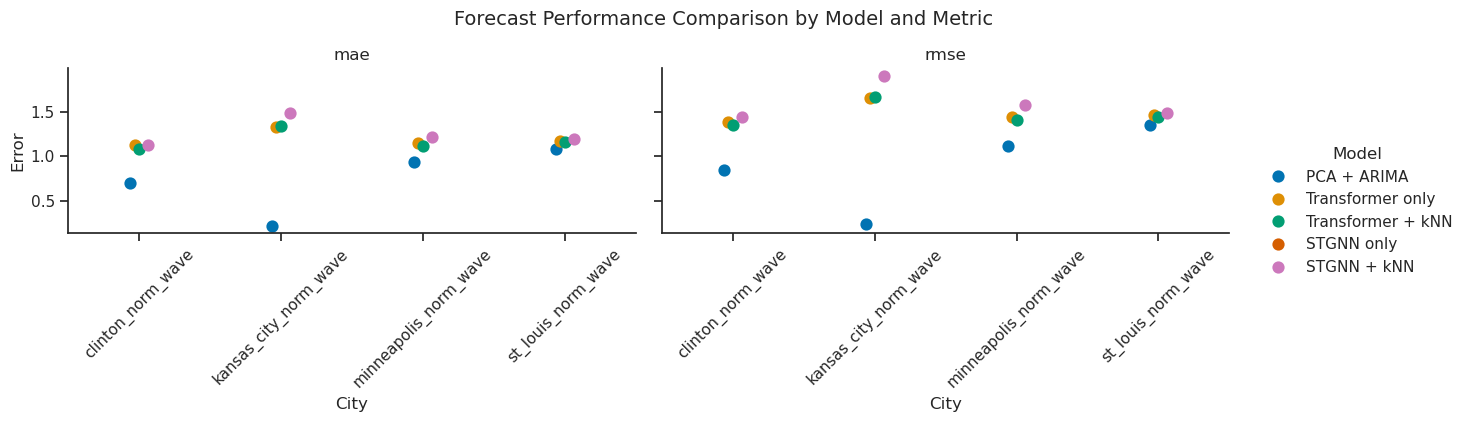

In [100]:
# Melt for faceted plotting
plot_df = combined_df.melt(id_vars=["city", "Model"], value_vars=["mae", "rmse"],
                           var_name="Metric", value_name="Value")

# Sort model order
model_order = ["PCA + ARIMA", "Transformer only", "Transformer + kNN", "STGNN only", "STGNN + kNN"]

# Create plot
g = sns.catplot(
    data=plot_df,
    x="city", y="Value", hue="Model", col="Metric",
    kind="point", dodge=True, markers="o", linestyles="",
    height=4, aspect=1.6, palette="colorblind", order=sorted(plot_df["city"].unique()),
    hue_order=model_order
)

# Beautify
g.set_titles("{col_name}")
g.set_axis_labels("City", "Error")
g.set_xticklabels(rotation=45)
g.tight_layout()
plt.suptitle("Forecast Performance Comparison by Model and Metric", y=1.05, fontsize=14)
plt.show()